In [1]:
import sys
import os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import os
import cv2
import glob
import copy
import torch
import random
from torch import nn
import timm
import timm_3d
from typing import List, Sequence, Tuple, Union, Dict
from scipy import ndimage

from MedicalNet.MedicalNet import Struct, MedNet
import yolov9_head_func_3d as y9

from PIL import Image
import pandas as pd
from typing import Literal
from collections import defaultdict
import numpy as np
from tqdm.notebook import tqdm

from torchvision.tv_tensors import BoundingBoxes as BB
from torchmetrics.detection import MeanAveragePrecision
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
from torchvision.ops import nms

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
torch.cuda.is_available()

True

postprocessing found bboxes:
Include guaranteed information about bboxes in image. 
-> 5 classes each with one bbox or 1 class with 5 bbox
-> If there exist level n-1 and n+1 in image there must also exist level n
-> The boxes of levels n-1, n, n+1 must be aligned next to another in heigh dimention
-> The boxes must overlap in x dimention to some extend 
-> If there exist series of boxes for levels n, n+1, n+2 and image height is bigger than mean level heigh than the n+3 level must also exist - same situation in reverse


# DATASET

In [4]:
class Bbox3d():
    def __init__(self, x, y, z) -> None:
        # 3d box in coordinates of sagittal series
        self.x = x
        self.y = y
        self.z = z
    
    def get_box_in_view_type(self, view_type, d3:bool=False):
        if view_type == 'sagittal':
            return self.get_sagittal(d3)
        elif view_type == 'coronal':
            return self.get_coronal(d3)
        elif view_type == 'axial':
            return self.get_axial(d3)
    
    def get_sagittal(self, d3:bool=False):
        if d3:
            return [self.x[0], self.y[0], self.x[1], self.y[1], self.z[0], self.z[1]]
        return [self.x[0], self.y[0], self.x[1], self.y[1]]

    def get_coronal(self, d3:bool=False):
        if d3:
            return [self.z[0], self.y[0], self.z[1], self.y[1], self.x[0], self.x[1]]
        return [self.z[0], self.y[0], self.z[1], self.y[1]]

    def get_axial(self, d3:bool=False):
        if d3:
            return [self.z[0], self.x[0], self.z[1], self.x[1], self.y[0], self.y[1]]
        return [self.z[0], self.x[0], self.z[1], self.x[1]]

In [5]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_info:Dict[str, pd.DataFrame], config:Dict):
        # data_info: dict consisting of series types and dataframe with their info
        # config: dict - dataset configuration
        #TODO: Better overlap in instance dimention
        #TODO: smart limit - selecting important slices based on series type and where they usually lay
        
        self.supress_warnings = config['supress_warinings']
        self.used_series_types = config['load_series']
        self.study_ids = np.unique(np.concatenate([series.study_id.unique() for series in data_info.values() if series is not None]))
        self.data_info = data_info
        if not np.all([tp in list(self.data_info.keys()) for tp in self.used_series_types]):
            raise Exception("Series types to use do not match provided data information.")
        
        self.series_out_types = config['series_out_types']
        self.current_view = self.series_out_types[0]
        self.return_series_type = config['return_series_type']

        self.d3 = True #config['3d_box'] if '3d_box' in list(config.keys()) else False
        self.preload = config['preload']
                 
        if self.preload and len(self.series_out_types)>1:
            self.preload = False
            if not self.supress_warnings:
                print("Preloading with mixed series type outputs is not supported. Preloading was turned off.")

        self.im_size = config['im_size']
        if self.im_size:
            self.resize = v2.Resize((self.im_size[1], self.im_size[0]))

        self.image_type = config['image_type']

        if self.preload and not self.supress_warnings:
            print("Warning! Preloading of images is turned on. The program will attempt to load whole dataset into memory!")
        
        self.transforms = config['transforms']
        self.normalize = config['normalize']
        self.vsa = config['vsa']
        
        self.dataset_type = config['dataset_type']
        self.dataset_path = config['dataset_path']

        self._condition_list = ['Left Neural Foraminal Narrowing', 
                                'Left Subarticular Stenosis', 
                                'Right Neural Foraminal Narrowing', 
                                'Right Subarticular Stenosis', 
                                'Spinal Canal Stenosis']
        
        self._status_map = {'Normal/Mild': [1., 0., 0.],
                            'Moderate': [0., 1., 0.],
                            'Severe': [0., 0., 1.]}
        
        self.level_ind = {'L1/L2': 0, 'L2/L3': 1, 'L3/L4': 2, 'L4/L5': 3, 'L5/S1':4}

        self.box_labels = torch.tensor([list(self.level_ind.values())]) 

        self.limit = config['limit_series_len']
        self.series_length = 15
        
        self.x_overhead = config['x_overhead'] if config['x_overhead'] else [30, 30]
        self.z_overhead = config['z_overhead']
        self.overlap_levels = config['overlap_levels']
        self.y_overlap = config['y_overlap'] if self.overlap_levels else 0
    
        if self.limit and not config['series_len'] and not self.supress_warnings:
            print("Series length is not specified. The limit is set to 15.")
        elif self.limit and config['series_len']:
            self.series_length = config['series_len']
            
        self.series_type_ind = {}
        for s in self.used_series_types:
            self.series_type_ind[s] = []

        self.data = []
        self.prepare_data()

    def get_level_boxes(self, series_info:pd.DataFrame, stype='sagittal'):
        #default for each scan has 5 visible levels
        bboxes = []
        labels = []
        if stype in ['sagittal', 'sagittal_t2']:
            for _, row in series_info.iterrows():
                sl = np.array(row.slice_locations)
                
                #z_overhead = -self.z_overhead if row.reversed else self.z_overhead
                fr_a = sl[row.present_instances.index(min(row.instance_number))]
                too_a = sl[row.present_instances.index(max(row.instance_number))]
                
                fr = min(fr_a, too_a)
                too = max(fr_a, too_a)
 
                z_min = np.argmin(abs(sl - (fr-self.z_overhead )))
                z_max = np.argmin(abs(sl - (too+self.z_overhead)))

                labels.append(self.level_ind[row.level])
                bboxes.append(Bbox3d(
                    x=[max(0, min(row.x)-self.x_overhead[0]/row.pixel_spacing[0]), min(row.image_width, max(row.x)+self.x_overhead[1]/row.pixel_spacing[0])],
                    y=[max(0, row.level_boundaries[0]-self.y_overlap/row.pixel_spacing[1]), min(row.image_height, row.level_boundaries[1]+self.y_overlap/row.pixel_spacing[1])],
                    z=[min(z_max, z_min), max(z_max, z_min)]))
                
        elif stype=='axial':
            y_overlap = 0.5 
            for _, row in series_info.iterrows():
                labels.append(self.level_ind[row.level])
                bboxes.append(Bbox3d(
                    x=[max(0, min(row.y)-self.x_overhead[0]/row.pixel_spacing[1]), min(row.image_width, max(row.y)+self.x_overhead[1]/row.pixel_spacing[1])],
                    y=[max(0, row.present_instances.index(min(row.level_slices))-y_overlap), min(len(row.present_instances), row.present_instances.index(max(row.level_slices))+y_overlap)],
                    z=[max(0, min(row.x)-self.z_overhead/row.pixel_spacing[0]), min(row.image_height, max(row.x)+self.z_overhead/row.pixel_spacing[0])]
                                ))

        return bboxes, np.array(labels)

    def set_view(self, new_view):
        self.current_view = new_view
        
    def get_condition_labels(self, series_info:pd.DataFrame):
        labels = []
        cond_presence_masks = []
        level_presence_mask = []

        for level, _ in self.level_ind.items():
            if not series_info[series_info['level']==level].empty:
                labels.append(series_info[series_info['level']==level].iloc[0].status)
                cond_presence_masks.append(series_info[series_info['level']==level].iloc[0].presence_mask)
                level_presence_mask.append(True)
            else:
                level_presence_mask.append(False)

        return np.array(labels), np.array(cond_presence_masks), np.array(level_presence_mask)

    def info2dict(self, series_info, stype=None): #remember axials can be combination of different serieses (sagittals can't)
        level0 = series_info.iloc[0]
        data_dict = {}
        boxes, box_labels = self.get_level_boxes(series_info, stype=stype)
        labels, label_level_mask, label_cond_mask = self.get_condition_labels(series_info)

        data_dict['study_id'] = level0.study_id
        data_dict['series_id'] = level0.series_id
        data_dict['width'] = level0.image_width
        data_dict['height'] = level0.image_height
        data_dict['reversed'] = level0.reversed
        data_dict['series_type'] = stype
        data_dict['pixel_spacing'] = level0.pixel_spacing

        data_dict['boxes'] = boxes 
        data_dict['files'] = [f"{self.dataset_path}/{data_dict['study_id']}/{data_dict['series_id']}/{instance}.{self.image_type}" for instance in level0.present_instances]
        data_dict['box_labels'] = box_labels
        data_dict['labels'] = labels
        data_dict['label_presence_mask'] = label_level_mask
        #data_dict['level_presence_mask'] = label_cond_mask
        
        return data_dict
   
    def prepare_data(self):
        # prepare paths for every image to load
        with tqdm(total=len(self.study_ids), desc="Preparing data: ") as pbar:
            for study_id in self.study_ids:
                study_dict = dict(
                                sagittal=[], 
                                sagittal_t2=[], 
                                axial=[])
                for stype in self.used_series_types:
                    for series_id in self.data_info[stype].query(f'study_id == {study_id}').series_id.unique():
                        ddict = self.info2dict(self.data_info[stype][self.data_info[stype].series_id==series_id], stype=stype)
                        if self.preload:
                            ddict = self.preload_series(ddict)
                        study_dict[stype].append(ddict)

                self.data.append(study_dict)
                pbar.update(1)

    def split_to_series(self):
        temp = []
        batches = []
        i=0
        for data in self.data:
            batch = []
            for series in data.values():
                if series:
                    temp+=series
                    batch.append(i)
                    i+=1
            batches.append(batch)

        self.data = temp
        self.batches = batches
    
    def change_img_view(self, img, current_view, new_view):
        if current_view in ['sagittal', 'sagittal_t2']:
            if new_view == 'sagittal':
                return img
            elif new_view=='coronal':
                return img.transpose(2, 1, 0) # n, h, w -> w, h, n
            elif new_view=='axial':
                return img.transpose(1, 2, 0 ) #n, h, w -> h, n, w
        elif current_view=='axial':
            if new_view =='sagittal':
                return img.transpose(2, 0, 1) # n, h, w -> w, n, h
            elif new_view =='coronal':
                return img.transpose(1, 0, 2) # n, h, w -> h, n, w
            elif new_view=='axial':
                return img
            
            
    def preload_series(self, data):

        boxes = torch.tensor(np.array([box.get_box_in_view_type(self.series_out_types[0], d3 = True) for box in data['boxes']]), dtype=torch.float)
        series = self.change_img_view(self.load_series(data), current_view = data['series_type'], new_view=self.series_out_types[0])
        #series, boxes = self.__drop_invalid_range__(series, boxes)
        series, boxes = self.__resize_data__(series, boxes)
        if data['series_type']=='sagittal' and data['reversed']:
            series = series[:,::-1,:]

        data['series'] = series
        data['o_series_type'] = data['series_type']
        data['series_type'] = self.series_out_types[0]

        for bc, bo in zip(data['boxes'], boxes):
            bc.x = bo[[0,2]].numpy()
            bc.y = bo[[1,3]].numpy()
            bc.z = bo[[4,5]].numpy()

        return data

            
    def load_series(self, data) -> np.ndarray:
        boxes = torch.tensor(np.array([box.get_box_in_view_type(self.series_out_types[0], d3 = True) for box in data['boxes']]), dtype=torch.float)
        oimg = np.zeros((len(data['files']), data['height'], data['width']), dtype = np.uint8)
        for i, path in enumerate(data['files']):  
            try:      
                oimg[i,:,:] = np.array(Image.open(path), dtype = np.uint8)
            except ValueError:
                temp = np.array(Image.open(path), dtype = np.uint8) 
                oimg[i,:temp.shape[0],:temp.shape[1]] = temp
                del temp

        if data['series_type'] != 'axial':
            oimg = oimg[::-1,:,:]
            for bc, bo in zip(data['boxes'], boxes):
                bc.z[0] = oimg.shape[0] - bo[5]
                bc.z[1] = oimg.shape[0] - bo[4]

        return oimg

    def sagitta_to_axial_res(self, img, boxes, pixel_spacing, p =0.2):
        ast = np.arange(2, 20, dtype=int)
        p = p
        if torch.rand(1) < p:
            slt = random.choice(ast)
            step = int(slt/pixel_spacing)
            img = img[:, 0::step, :]
            boxes[:, [1,3]] /= step

        return img, boxes

    def cut_by_boxes(self, img, boxes, labels, cut_n = 3, min_b = 2, crop_mb = True):
        # drop visible boxes and cut image to not include them
        last_i = boxes.size(0)
        if (last_i < 5 and crop_mb) or last_i==5:
            if last_i < 5:
                bb_to_cut = 0
            else:
                bb_to_cut = torch.randint(0, min(last_i-min_b+1, cut_n+1),(1,))

            for _ in range(bb_to_cut): #randomly select first or last level to drop
                if torch.rand(1)>0.5:
                    boxes = boxes[1:,:]
                    labels = labels[1:]
                else:
                    boxes = boxes[:-1,:]
                    labels = labels[:-1]

            cut_from = int(min(boxes[0,1], boxes[-1,1]))
            cut_to =  int(max(boxes[0,3], boxes[-1,3]))

            if (labels[0] == 0 and boxes[0,1] < boxes[-1,1]) or \
                (labels[-1]==4 and boxes[0,1] > boxes[-1,1]):
                cut_from = 0
            if (labels[0] == 0 and boxes[0,3] > boxes[-1,3]) or \
                (labels[-1]==4 and boxes[0,3] < boxes[-1,3]):
                cut_to = img.shape[1]
        
            up_room = torch.randint(0, 5, (1,))
            bot_room = torch.randint(0, 5, (1,))
            img = img[:,max(0, cut_from-up_room):min(img.shape[1], cut_to+bot_room),:]
            if cut_from != 0:
                boxes[:,[1,3]] = boxes[:,[1,3]]-cut_from+up_room
                

        return img, boxes, labels
    
    def cut_to_boxes(self, img, boxes, labels):
        # cut image part above and below of present boxes
        cut_from = int(min(boxes[0,1], boxes[-1,1]))
        cut_to =  int(max(boxes[0,3], boxes[-1,3]))

        img = img[:,max(0, cut_from):min(img.shape[1], cut_to),:]
        if cut_from != 0:
            boxes[:,[1,3]] = boxes[:,[1,3]]-cut_from
            

        return img, boxes, labels
    
    def box_volume_transforms(self, img, boxes, labels, p=0.2):
        if torch.rand(1) < p:
            if torch.rand(1)>0.5:
                img, boxes, labels = self.cut_by_boxes(img, boxes, labels)
            if torch.rand(1)>0.5:
                img, boxes, labels = self.cut_to_boxes(img, boxes, labels)

        return img, boxes, labels

    
    def __itensity_normalize_one_volume__(self, volume):
        """
        normalize the itensity of an nd volume based on the mean and std of nonzeor region
        inputs:
            volume: the input nd volume
        outputs:
            out: the normalized nd volume
        """
        out = (volume - 0.5*255.)/(0.5 *255.)
        '''
        pixels = volume[volume > 0]
        if pixels.size==0:
            return volume
        
        mean = pixels.mean()
        std  = pixels.std()
        out = (volume - mean)/std
        #out_random = np.random.normal(0, 1, size = volume.shape)
        #out[volume == 0] = out_random[volume == 0]
        '''
        return out

    def __resize_data__(self, data, bb):
        """
        Resize the data to the input size
        """ 
        [depth, height, width] = data.shape
        scale = [self.series_length*1.0/depth, self.im_size[1]*1.0/height, self.im_size[0]*1.0/width] 
        bb[..., [0,2]] = bb[..., [0,2]]/width*self.im_size[1]
        bb[..., [1,3]] = bb[..., [1,3]]/height*self.im_size[0]
        bb[..., [4,5]] = bb[..., [4,5]]/depth*self.series_length

        data = ndimage.zoom(data, scale, order=1)

        return data, bb
    
    def __drop_invalid_range__(self, volume, boxes):
        """
        Cut off the invalid area
        """
        zero_value = volume[0, 0, 0]
        non_zeros_idx = np.where(volume != zero_value)
        
        [max_z, max_h, max_w] = np.max(np.array(non_zeros_idx), axis=1)
        [min_z, min_h, min_w] = np.min(np.array(non_zeros_idx), axis=1)
        
        boxes[..., [0,2]] -= min_w
        boxes[..., [1,3]] -= min_h
        
        return volume[min_z:max_z, min_h:max_h, min_w:max_w], boxes 
    
    def limit_series(self, img, z_bb=None):
        if self.series_length < img.shape[0]:
                if self.d3:
                    z_bb = z_bb* self.series_length/img.shape[0]
                st = np.round(np.linspace(0, img.shape[0] - 1, self.series_length)).astype(int)
                img = img[st,:,:]
        elif self.series_length > img.shape[0]:
                img = F.pad(img, (0, 0, 0, 0, 0, self.series_length-img.shape[0]))
        return img, z_bb

    
    def prepare_series(self, img, data, view = None):
        if view is None:
            view = data['series_type']

        #oimg = self.load_series(data, preloaded=self.preload)
        img = self.change_img_view(img, current_view = data['series_type'], new_view=view)
        boxes = torch.tensor(np.array([box.get_box_in_view_type(view, d3 = self.d3) for box in data['boxes']]), dtype=torch.float)
        level_labels = torch.tensor(data['box_labels'], dtype=torch.float)
        cond_labels = torch.tensor(data['labels'])
        cond_masks = torch.tensor(data['label_presence_mask'])
        #if not self.preload:
            #img, boxes = self.__drop_invalid_range__(img, boxes)
            
        if self.vsa:
            if data['series_type'] != 'axial':
                img, boxes = self.sagitta_to_axial_res(img, boxes, data['pixel_spacing'][1], p =.0)
                if torch.rand(1)>0.75:
                    img, boxes, level_labels = self.cut_by_boxes(img, boxes, level_labels)
                if torch.rand(1)>0.75:
                    img, boxes, level_labels = self.cut_to_boxes(img, boxes, level_labels)
        
        img, boxes = self.__resize_data__(img, boxes)
        
        if self.d3:
            z_bb = torch.zeros((5,2), dtype = boxes.dtype)
            z_bb[level_labels.to(dtype=int),:] = boxes[..., [-2, -1]]
            boxes = boxes[..., 0:4]
            
        if self.normalize:
            img = self.__itensity_normalize_one_volume__(img)

        boxes = BB(boxes, format='XYXY', canvas_size=(img.shape[1] , img.shape[2]), dtype=torch.float)
        if self.transforms:
            target = {
                "boxes": boxes,
                "labels": level_labels,
                "series_type": data['series_type'],
                "pixel_spacing": data['pixel_spacing'][1]}
            
            img, target = self.transforms(torch.tensor(img,dtype=torch.float), target)

        boxes = target['boxes']
        level_labels = target['labels']

        #boxes = torch.cat([boxes, z_bb[level_labels.to(dtype=int),:]], dim=-1)
        xy_united = torch.zeros((5, 4), dtype = boxes.dtype)
        xy_united[level_labels.to(dtype=int),:] = boxes
        
        z_united = torch.zeros((5, 2), dtype=z_bb.dtype)
        z_united[level_labels.to(dtype=int),:] = z_bb[level_labels.to(dtype=int),:]

        boxes_united = torch.zeros((5, 6), dtype=boxes.dtype)
        boxes_united[:,[0,1,3,4]] = xy_united
        boxes_united[:,[2,5]] = z_united
        boxes_united = boxes_united.clamp(
            min=torch.tensor([0.,0.,0.,0.,0.,0.], dtype = torch.float), max=torch.tensor([img.shape[0], img.shape[1], img.shape[2], img.shape[0], img.shape[1], img.shape[2]], dtype = torch.float))
        return img, boxes_united, level_labels, cond_labels, cond_masks
    
    def __getitem__(self, index: int):
        return None
        
    def __len__(self):
        return(len(self.data))

In [6]:
class BoxDatasetUnited(Dataset):
    def __init__(self, data_info:Dict[str, pd.DataFrame], config:Dict):
        super(BoxDatasetUnited, self).__init__(data_info, config)

        self.mix_strategy = config['mix_strategy']
        if config['one_label']:
            self.box_labels = torch.tensor([0,0,0,0,0], dtype=torch.float)
        else:
           self.box_labels = torch.tensor([list(self.level_ind.values())]) 

        #split data to individual serieses from dict of study-series_type pairs
    
    def __getitem__(self, index: int)->tuple[np.ndarray, np.ndarray]:

        adata = self.data[index]

        # limit series (if limit==True)
        all_view_img = []
        all_view_boxes = []
        all_view_labels = []
        keys = []
        for key, data_list in adata.items():
            if data_list:
                keys.append(key)
                for data in data_list:
                    if not self.preload:
                        oimg = self.load_series(data)
                    else:
                        oimg = data['series']
                    img, boxes, level_labels, cond_labels, cond_masks = self.prepare_series(oimg, data, 'sagittal')
                    all_view_img.append(img)
                    all_view_boxes.append(boxes)
                    all_view_labels.append(self.box_labels)
                
        all_view_img = torch.stack(all_view_img).reshape(-1, self.series_length, self.im_size[1], self.im_size[0])
        all_view_boxes = torch.stack(all_view_boxes).reshape(-1, 5, 4 if not self.d3 else 6)
        all_view_labels = torch.stack(all_view_labels).reshape(-1, 5, 1)

        if self.return_series_type:
            return all_view_img, all_view_boxes, all_view_labels, keys
        
        return all_view_img, all_view_boxes, all_view_labels
    
    def __len__(self):
        return(len(self.data))
    
    def get_random_by_stype(self):
        return self[random.randint(0, len(self)-1)]

In [7]:
class BoxDataset(Dataset):
    def __init__(self, data_info:Dict[str, pd.DataFrame], config:Dict):
        super(BoxDataset, self).__init__(data_info, config)

        self.mix_strategy = config['mix_strategy']
        if config['one_label']:
            self.box_labels = torch.tensor([0,0,0,0,0], dtype=torch.float)
        else:
           self.box_labels = torch.tensor([list(self.level_ind.values())]) 
        #split data to individual serieses from dict of study-series_type pairs
        self.split_to_series()
    
    def __getitem__(self, index: int)->tuple[np.ndarray, np.ndarray]:

        if self.mix_strategy == 'random':
            new_view = [random.choice(self.series_out_types)]
        elif self.mix_strategy == 'combined': 
            new_view = self.series_out_types
        else:
            new_view = [self.current_view]

        data = self.data[index]

        if not self.preload:
            oimg = self.load_series(data)
        else:
            oimg = data['series']
        # limit series (if limit==True)
        all_view_img = []
        all_view_boxes = []
        all_view_labels = []
        l = len(new_view)
        for view in new_view:
            img, boxes, level_labels, cond_labels, cond_masks = self.prepare_series(oimg, data, view)
            all_view_img.append(img)
            all_view_boxes.append(boxes)
            all_view_labels.append(self.box_labels)
        
        all_view_img = torch.stack(all_view_img).reshape(l, self.series_length, self.im_size[1], self.im_size[0])
        all_view_boxes = torch.stack(all_view_boxes).reshape(l, 5, 4 if not self.d3 else 6)
        all_view_labels = torch.stack(all_view_labels).reshape(l, 5, 1)

        if self.return_series_type:
            return all_view_img, all_view_boxes, all_view_labels, data['series_type']
        
        return all_view_img, all_view_boxes, all_view_labels
    
    def __len__(self):
        return(len(self.data))

In [8]:
im_size = 128

train_transforms = v2.Compose([
    v2.RandomVerticalFlip(p = 0.0), #flip
    #v2.GaussianBlur(kernel_size=(7,7), sigma=(0.1, 0.1)),
    #v2.RandomAffine(degrees=5, translate=(0.1,0.1), shear=(-7,7,-7,7)), # translation + shearing
    #v2.RandomAffine(degrees=0, scale=(0.85,1.2)), #scaling
])

val_transforms = v2.Compose([
    v2.Resize((im_size,im_size)), #resize
])

train_dataset_config ={
    'preload': True, # preload data into memory (WARNING IT MAY TAKE A LOT OF SPACE - DEPENDS ON THE DATASET USED)
    'im_size': [im_size, im_size],
    'dataset_path': "/workspaces/RSNA_LSDC/inputs/dataset",
    'load_series': ['sagittal', 'axial', 'sagittal_t2'], # series types to load into dataset ['sagittal', 'axial', 'sagittal_t2']
    'united': True,

    'transforms': train_transforms,
    'vsa': False,
    'one_label': False, # use one label for every level (do not differentiate between levels)
    'series_out_types': ['sagittal'], # mix output series types to get views necessary to create 3d box ['sagittal', 'coronal']
    'mix_strategy': 'combined', # strategy for mixing output series types ['random', 'custom', 'combined'] random - randomly select output type, 
                              #'manual' - will return data based on currently choosen view, 'combined' will return all views in one call
    'return_series_type': False, # If True getitem will also return series orignial type
    
    'normalize': True,
    'image_type': 'png',
    'preload': False,

    'dataset_type': 'boxes', #'boxes', 'conditions'
    'supress_warinings': False, 

    'limit_series_len': True, # if True the series length will be limited to number N specified by 'series_len' parameter
    'series_len': 128, #  maximal number of slices in series

    'x_overhead': [20,20], # overhead for levels in x-dim (in mm)
    'z_overhead': 20,
    'overlap_levels': False, # if true the level upper and lower boundary will overlap with value specified in 'y_overlap'
    'y_overlap': 1, # overlap size of levels boundaries (in mm)
    '3d_box': True
}

tsd = pd.read_csv(f'/workspaces/RSNA_LSDC/inputs/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')#.iloc[0:100]
tsd = tsd[tsd["study_id"] == 109454808]
data_sagittal = pd.read_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_unified_sagital_t1.pkl")
data_sagittal_t2 = pd.read_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_unified_sagital_t2.pkl")
data_axial = pd.read_pickle('/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_axial_unified.pkl')
train_ids = tsd.study_id.unique()

train_data={'sagittal': data_sagittal[data_sagittal.study_id.isin(train_ids)],
            'sagittal_t2': data_sagittal_t2[data_sagittal_t2.study_id.isin(train_ids)],
            'axial': data_axial[data_axial.study_id.isin(train_ids)]}

bb = BoxDatasetUnited(train_data, train_dataset_config)

Preparing data:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([5, 128, 128, 128])


/tmp/ipykernel_14210/2907663376.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = color_dict[int(l)]


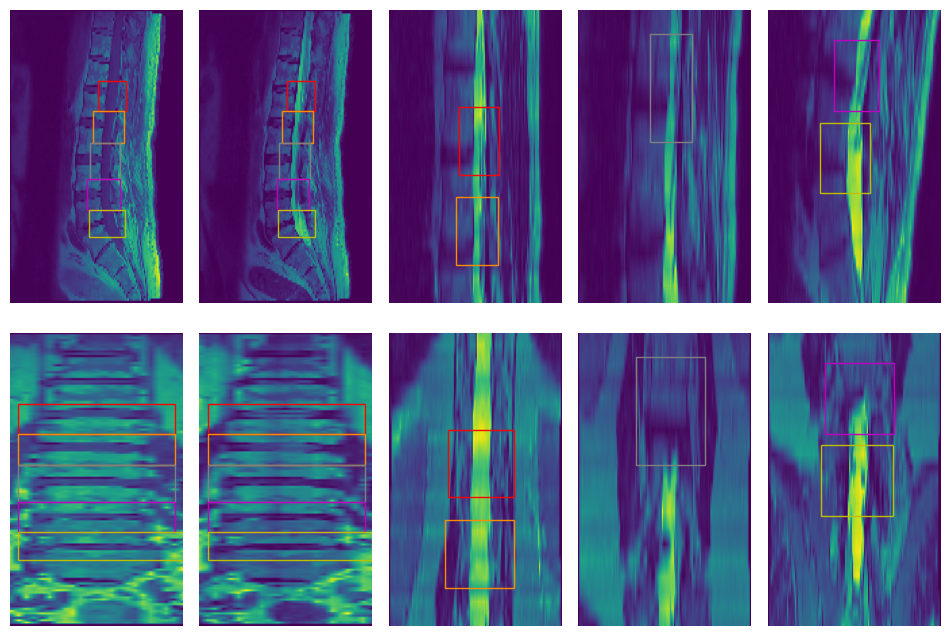

In [9]:
color_dict = dict([(0,'r'),(1,'darkorange'), (2,'gray'), (3,'m'), (4, 'y')])
#color_dict = dict([('L1/L2','r'),('L2/L3','darkorange'), ('L3/L4','gray'), ('L4/L5','m'), ('L5/S1', 'y')])
#fig, ax = plt.subplots(5, 2, figsize = (12, 8))
inputs, boxes, labels = bb[0]
#imgs.append(inputs)
print(inputs.shape)
fig, ax = plt.subplots(2, inputs.shape[0], figsize = (12, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
# print ground truth
for i, (img, box, label) in enumerate(zip(inputs, boxes, labels)):
    ax[0,i].imshow(img[int(img.size(0)/2),:,:].detach().cpu().numpy(), aspect = "auto")
    ax[1,i].imshow(img.permute(2,1,0)[int(img.size(0)/2),:,:].detach().cpu().numpy(), aspect = "auto")

    for j in range(box.shape[0]):
        b_sag = box[j,[0,1,3,4]].numpy()
        b_cor = box[j,[2,1,5,4]].numpy()
        l = label[j].numpy()
        color = color_dict[int(l)]
        ax[0,i].add_patch(patches.Rectangle((b_sag[0], b_sag[1]), b_sag[2]-b_sag[0], b_sag[3]-b_sag[1], linewidth=1, edgecolor=color, facecolor='none'))
        ax[1,i].add_patch(patches.Rectangle((b_cor[0], b_cor[1]), b_cor[2]-b_cor[0], b_cor[3]-b_cor[1], linewidth=1, edgecolor=color, facecolor='none'))
    ax[0,i].axis('off')
    ax[1,i].axis('off')

#plt.show()

# MODEL TRAINER

In [32]:
class SagittalTrainer():
    def __init__(self, model, model_params, config, train_data, eval_data) -> None:

        self.print_evaluation = config["print_evaluation"] if "print_evaluation" in config else False
        self.steps_per_plot = config["steps_per_plot"]

        if config['train_dataset_config']['mix_strategy'] and len(config['train_dataset_config']['series_out_types'])>1:
            print("Warning! With mix strategy set to 'combined' and multiple series out types the batch size will be (len(series_out_types)) times bigger.")

        self.checkpoints = config['checkpoints']
        self.save_path = config['save_path']
        self.step_per_save = config['step_per_save']

        self.config = config

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Device set to {self.device}")

        self.model_name = config['model_name']
        self.model = model(**model_params).to(self.device)
        #self.model.to(self.device)
        
        self.optimizer = config["optimizer"](self.model.parameters(),**config["optimizer_params"])

        self.series_len = config['val_dataset_config']['series_len']
        self.dataloaders = {'train': torch.utils.data.DataLoader(BoxDatasetUnited(train_data, config['train_dataset_config']), batch_size=config["batch_size"], shuffle=True, num_workers=12, prefetch_factor=1),
                           'val': torch.utils.data.DataLoader(BoxDatasetUnited(eval_data, config['val_dataset_config']), batch_size=config["batch_size"], shuffle=False, num_workers=12, prefetch_factor=1)}
        
        self.max_epochs = config["epochs"]
        self.early_stopping = config['early_stopping']
        self.early_stopping_tresh = config['early_stopping_treshold']

        # scheduler
        if config["scheduler"]:
            if 'epochs' in list(config['scheduler_params'].keys()):
                config['scheduler_params']['epochs'] = self.max_epochs
            if 'steps_per_epoch' in list(config['scheduler_params'].keys()):
                config['scheduler_params']['steps_per_epoch'] = len(self.dataloaders['train'])
            self.scheduler = config["scheduler"](self.optimizer,**config["scheduler_params"])
            self.one_cycle_sched = self.scheduler.__class__.__name__ == 'OneCycleLR'
        else:
            self.scheduler = None
        
        ## Evaluation metrics
        self.save_model = config['save_model']
        self.series_in_types = config['train_dataset_config']['load_series']
        self.out_stypes = config['train_dataset_config']['series_out_types']
        self.batch_size = config["batch_size"] * len(self.out_stypes)

        self.mAP = MeanAveragePrecision(box_format = 'xyxy', iou_type='bbox', extended_summary=True).to(self.device)
        self.all_maps = []
        self.mAP_split = []
        self.best_map = 0
        self.metrics_to_print = ['map', 'map_50', 'map_75', 'map_per_class']

    def save_model(self):
        torch.save(self.model.state_dict(), os.path.join(self.save_path, f"{self.model_name}_best.pt"))

    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path))

    def train(self):
        for epoch in range(self.max_epochs):
            print(f"Epoch {epoch+1}/{self.max_epochs}")
            self.train_one_epoch()
            self.eval_one_epoch()
            #print examples
            if (epoch+1)%self.steps_per_plot==0:
                self.plot_examples()
            #checkpoint
            if epoch%5==0:
                pass

    def train_one_epoch(self):

        self.model.train()  # Set model to training mode
        metrics = defaultdict(list)
        
        with tqdm(self.dataloaders['train'], unit = "batch",
                    total = len(self.dataloaders['train'])) as tepoch:
            for inputs, boxes, labels in self.dataloaders['train']:
                with torch.set_grad_enabled(True):
                    loss, loss_info = self.model.get_loss(inputs.to(self.device).reshape(-1, self.series_len, inputs.shape[-2], inputs.shape[-1]), 
                                                          boxes.to(self.device).reshape(-1, 5, 6), 
                                                          labels.to(self.device).reshape(-1, 5, 1))
                    for loss_t, loss_v in loss_info.items():
                        metrics[loss_t].append(loss_v.clone().detach().cpu().numpy())
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    if self.scheduler and self.one_cycle_sched:
                        self.scheduler.step()

                #update tqdm data
                tepoch.set_description(self.metrics_description(metrics, 'train'))
                tepoch.update(1)

        if self.scheduler and not self.one_cycle_sched:
            self.scheduler.step()


    def eval_one_epoch(self):
        self.model.eval()
        targets = []
        preds = []
        stypes = []

        with tqdm(self.dataloaders['val'], unit = "batch",
                            total = len(self.dataloaders['val'])) as tepoch:
            for inputs, boxes, labels, stype in self.dataloaders['val']: 
                with torch.set_grad_enabled(False):   
                    out = self.model.predict(inputs.to(self.device).reshape(-1, self.series_len, inputs.shape[-2], inputs.shape[-1])) # reshape input to accomodate multiple view outputs
                    
                    for pred in out:
                        pred['boxes']= pred['boxes'][..., [0,1,3,4]]
                    preds += out
                    targets += [dict(boxes=box.to(self.device)[(box != 0).any(dim=-1).nonzero()].squeeze(1), 
                                     labels=label.to(self.device)[(box != 0).any(dim=-1).nonzero()].squeeze((1,2)).to(torch.int)) 
                                     for box, label in zip(boxes[..., [0,1,3,4]].reshape(-1,5,4), labels.reshape(-1,5,1))]
                    
                    stypes += [st for st in stype]
                    tepoch.update(1)
                
        self.mAP.update(preds=preds, target=targets)
        all_maps = {k: v for k, v in self.mAP.compute().items()}
        self.all_maps.append(all_maps)
        self.mAP.reset()
        if all_maps['map'] > self.best_map and self.save_model:
            self.save_model()
            self.best_map = all_maps['map']
            
        # divide preds and targets by out stypes
        st_t, st_p = {}, {}
        if len(self.out_stypes)>1:
            for i, st in enumerate(self.out_stypes):
                st_t[st] = targets[i::len(self.out_stypes)]
                st_p[st] = preds[i::len(self.out_stypes)]

        #print validation metrics
        validation_log =[]
        validation_log.append("All mAP validation metrics: " + self.get_map_str(all_maps))
        # divide further by in series types
        if len(self.out_stypes)>1 or len(self.series_in_types)>1:
            map_split_in = {}
            for sintype in self.series_in_types:
                str = 'Validation mAP for input series with type '+sintype+': \n'
                map_split_out = {}
                for i, st in enumerate(self.out_stypes): 
                    str += "    For output series with type "+st+": "
                    st_t= targets[i::len(self.out_stypes)] # targets in out type 
                    st_p = preds[i::len(self.out_stypes)] # targets in in type
                    #select indices of given series in type
                    st_ind = np.where(np.array(stypes)==sintype)[0].astype(int)
                    self.mAP.update(preds=[st_p[j] for j in st_ind], 
                                    target=[st_t[j] for j in st_ind])
                    map_split_out[st] = {k: v for k, v in self.mAP.compute().items()}
                    self.mAP.reset()
                    str += self.get_map_str(map_split_out[st])+" \n"

                map_split_in[sintype] = map_split_out
                validation_log.append(str)
            self.mAP_split.append(map_split_in)
        
        if self.print_evaluation:
            for str in validation_log:
                print(str)

    
    def get_map_str(self, map: Dict):
        str = ""
        for k, v in map.items():
            if k in self.metrics_to_print:
                str+= f"{k}: {v}"
                str+= " || "
        return str

    def plot_examples(self, plot_num:int=1):
        color_dict = dict([(0,'r'),(1,'g'), (2,'b'), (3,'m'), (4, 'y')])
        self.model.eval()
        for i in range(plot_num):#sin_type in self.series_in_types[0]:
            fig, ax = plt.subplots(2, 2*3, figsize = (16, 8))
            for a in ax.ravel():
                a.set_axis_off()
                a.set_yticklabels([])
                a.set_xticklabels([])
            #if len(self.out_stypes)<2:
                #ax = np.expand_dims(ax, axis=1)
            #fig.suptitle(f"Example plot for input series with type {sin_type}.", fontsize=12)
            inputs, boxes, labels, stype = self.dataloaders['val'].dataset.get_random_by_stype()
           
            with torch.set_grad_enabled(False):
                preds = self.model.predict(inputs.to(self.device).reshape(-1, self.series_len, inputs.shape[-2], inputs.shape[-1])) # predict 
            # print ground truth
            for i, (img, box, label, st, pred) in enumerate(zip(inputs, boxes, labels, stype, preds)):
                ax[0,0+2*i].imshow(img[int(self.series_len/2),:,:].detach().cpu().numpy())
                ax[1,0+2*i].imshow(img[int(self.series_len/2),:,:].detach().cpu().numpy())

                ax[0,1+2*i].imshow(img.permute(2,1,0)[int(self.series_len/2),:,:].detach().cpu().numpy())
                ax[1,1+2*i].imshow(img.permute(2,1,0)[int(self.series_len/2),:,:].detach().cpu().numpy())

                for j in range(box.shape[0]):
                    b_sag = box[j,[0,1,3,4]].numpy()
                    b_cor = box[j,[2,1,5,4]].numpy()
                    l = label[j].numpy()
                    color = color_dict[int(l)]
                    ax[0,0+2*i].add_patch(patches.Rectangle((b_sag[0], b_sag[1]), b_sag[2]-b_sag[0], b_sag[3]-b_sag[1], linewidth=1, edgecolor=color, facecolor='none'))
                    ax[0,1+2*i].add_patch(patches.Rectangle((b_cor[0], b_cor[1]), b_cor[2]-b_cor[0], b_cor[3]-b_cor[1], linewidth=1, edgecolor=color, facecolor='none'))
                    
                for j in range(len(pred['boxes'])):
                    b_sag = pred['boxes'][j, [0,1,3,4]].cpu().numpy()
                    b_cor = pred['boxes'][j, [2,1,5,4]].cpu().numpy()
                    l = pred['labels'][j].cpu().numpy()
                    color = color_dict[int(l)]
                    ax[1,0+2*i].add_patch(patches.Rectangle((b_sag[0], b_sag[1]), b_sag[2]-b_sag[0], b_sag[3]-b_sag[1], linewidth=1, edgecolor=color, facecolor='none'))
                    ax[1,1+2*i].add_patch(patches.Rectangle((b_cor[0], b_cor[1]), b_cor[2]-b_cor[0], b_cor[3]-b_cor[1], linewidth=1, edgecolor=color, facecolor='none'))
            plt.subplots_adjust(wspace=0.1, hspace=0)
            plt.show()
                

    def metrics_description(self, metrics:dict, phase:str)->str:
        outputs = phase + ": ||"
        for k in metrics.keys():
            outputs += (" {}: {:4f} ||".format(k, np.mean(metrics[k])))
        return outputs
    
    def get_summary(self, desc:str = None):
        # desc (str): additional description to include
        
        summary = {
            'model_name': self.model_name,
            'backbone': self.model.backbone_name,
            'conv_type': self.model.head_conv_mode,
            'use_reg_for_cls': self.model.use_reg_for_cls,
            'mix_strategy': self.config['train_dataset_config']['mix_strategy']
        }
        #find epoch with best mAP
        all_map = [epm['map'] for epm in self.all_maps]
        best_epoch = np.argmax(all_map)
        summary['best_epoch'] = best_epoch

        # append general metrics
        for key, val in self.all_maps[best_epoch].items():
            if key in self.metrics_to_print:
                summary[f"general_{key}"] = val
        
        if self.mAP_split:
            for map_split_in_name, map_split_in in self.mAP_split[best_epoch].items():
                for map_split_out_name, map_split_out in map_split_in.items():
                    for key, val in map_split_out.items():
                        if key in self.metrics_to_print:
                            summary[f"{map_split_in_name}_{map_split_out_name}_{key}"] = val
        if desc:
            summary['description'] = desc
            
        return summary


In [33]:
class Nms3d(nn.Module):
    def __init__(self, iou_treshold=0.3, score_treshold = 0., del_dup_class=False) -> None:
        super().__init__()
        self.score_tr = score_treshold
        self.iou_tr = iou_treshold
        self.del_dup_class = del_dup_class

    def forward(self, results):
        # boxes in format [score, label, x, y, z, x, y, z]
        result = results.clone().detach()
        result = result[result[:,0].argsort(dim=0, descending=True)] # sort by score 
        result = result[result[:,0] >= self.score_tr] # score tr
        
        if result.nelement() == 0:
            return result
        
        filtered = []
        while result.nelement() != 0:
            filtered.append(result[[0]])
            ious = y9.bbox_iou(result[0, 2:], result[:, 2:], iou_mode=True)
            if self.del_dup_class:
                result = result[torch.logical_and(ious.squeeze()<=self.iou_tr, result[:,1]!=result[0, 1])]
            else:
                result = result[ious.squeeze()<=self.iou_tr]

        return torch.cat(filtered, dim=0)
      

In [34]:
class BoxModel(nn.Module):
    def __init__(self, backbone_name:str, series_dim:list[int], num_classes:int=1,
                 use_features:Union[str, list[int]]=[0], reg_max:int=16, pretrained:bool=False,
                 head_conv_mode:str = '2d', use_reg_for_cls:bool = False):
        # backbone_name - timm model to use as backbone
        # series_dim - dimentionality of the series [num_channels, im_width, im_height]
        # use_features - features to use from backbone output:
        #        example model outputs features with dim [64, 64, 128, 256, 512] 
        #               'last' or [0] will take only last layer
        #               'all' will take all layers
        #               [0, 1, 2] will take last three layers

        super().__init__()
        # model outputs bounding box in yolo format [x_mid, y_mid, width, height] (normalized)
        # chose feature extractor from timm models
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.num_classes = num_classes
        self.series_dim = series_dim
        self.backbone_name = backbone_name
        if 'resnet' in backbone_name:
            opts = {
            'model': 'resnet',
            'device': self.device,
            'phase': 'train',
            }
            model_pretrained_params = {
                'resnet_10': {'model_depth': 10, 'resnet_shortcut': 'B'},
                'resnet_10_23dataset': {'model_depth': 10, 'resnet_shortcut': 'B'},
                'resnet_18': {'model_depth': 18, 'resnet_shortcut': 'A'},
                'resnet_18_23dataset': {'model_depth': 18, 'resnet_shortcut': 'A'},
                'resnet_34': {'model_depth': 34, 'resnet_shortcut': 'A'},
                'resnet_34_23dataset': {'model_depth': 34, 'resnet_shortcut': 'A'}
            }
            for model_name, model_dict in model_pretrained_params.items():
                model_pretrained_params[model_name] = Struct({**model_dict, **opts})

            def construct_network(feature_extractor, model_pretrained_params):
                model = MedNet(feature_extractor, model_pretrained_params)
                return model

            self.feature_extractor = construct_network('resnet_18_23dataset', model_pretrained_params).to(self.device)
            self.feature_extractor.init_FE(self.device, '/workspaces/RSNA_LSDC/MedicalNet/Pretrained/resnet_18_23dataset.pth')

            self.all_channels = [64, 128, 256, 512]
            self.reduction = [4, 8, 8, 8]
        else:
            self.feature_extractor = timm_3d.create_model(
                                            backbone_name,
                                            pretrained=True,
                                            features_only=True,
                                            in_chans=1
                                        )
                                                
            self.all_channels = self.feature_extractor.feature_info.channels()
            self.reduction = self.feature_extractor.feature_info.reduction()
        # features dimention
        if use_features=='all':
            self.in_channels = self.all_channels
            self.featmap_stride = self.reduction
            self.fl = list(range(len(self.all_channels)))
        elif use_features=='last':
            self.in_channels = [self.all_channels[-1]]
            self.featmap_stride = [self.reduction[-1]]
            self.fl = [len(self.all_channels)-1]
        elif type(use_features)==list:
            self.in_channels = [self.all_channels[len(self.all_channels)-(1+i)] for i in sorted(use_features, reverse=True)]
            self.featmap_stride = [self.reduction[len(self.reduction)-(1+i)] for i in sorted(use_features, reverse=True)]
            self.fl= [len(self.all_channels)-(1+i) for i in sorted(use_features, reverse=True)]

        self.head_conv_mode = head_conv_mode
        self.use_reg_for_cls = use_reg_for_cls

        self.postprocess = Nms3d(0.3, 0.2, True)
        self.head = y9.Detect3d(nc=num_classes, ch=self.in_channels, strides=self.featmap_stride, reg_max=reg_max)
        h = {
            "device": self.device,
            "cls_pw":None,
            "label_smoothing": 0.0,
            "fl_gamma": 0.0
        }
        self.CL = y9.ComputeLoss(self.head, h)

    
    def forward(self, x: torch.Tensor) -> Tuple[List]:
        """Forward features from the upstream network.

        Args:
            x (Tensor): input series
        Returns:
            Tuple[List]: A tuple of multi-level classification scores, bbox
            predictions
        """
    
        x = self.feature_extractor(x.unsqueeze(1))
        x = [x[i] for i in self.fl]

        #for j in x:
            #print(j.shape)
            
        return self.head(x)

    def get_loss(self, series, gt_boxes, gt_labels):
        head_out = self.forward(series)  
        loss, loss_split, pred_a_boxes = self.CL(head_out,
                                        gt_boxes, gt_labels)
        metrics = dict(loss_cls=loss_split[1], loss_bbox=loss_split[0], loss_dfl=loss_split[2])

        return loss, metrics
    
    def get_predictions(self, series, gt_boxes, gt_labels):
        result_list = []
        head_out = self.forward(series)  
        loss, loss_split, pred_a_boxes = self.CL(head_out,
                                        gt_boxes, gt_labels)
        #print(pred_a_boxes.shape)
        for result in pred_a_boxes:
            if result.nelement() == 0:
                result_list.append({'boxes': result, 'scores': result, 'labels': result.int()})
            else:
                result_list.append({'boxes': result[:, 2:], 'scores': result[:, 0], 'labels': result[:, 1].int()})
        return result_list

    def predict(self, series):
        scores, labels, dbox = self.forward(series)
        result_list = []
        for score, label, boxes in zip(scores, labels, dbox):
            result = self.postprocess(torch.cat((score, label, boxes), dim=0).permute(1,0))
            result_list.append({'boxes': result[:, 2:], 'scores': result[:, 0], 'labels': result[:, 1].int()})
        return result_list


# Training model

In [35]:
im_size = 96

train_transforms = v2.Compose([
    v2.RandomChoice([v2.RandomVerticalFlip(p = 0.5), v2.RandomHorizontalFlip(p = 0.5)]), #flip
    v2.RandomChoice([v2.RandomAffine(degrees=20), v2.RandomAffine(degrees=0, translate=(0.3,0.3), shear=(-7,7,-7,7))]), # translation + shearing
    v2.RandomAffine(degrees=0, scale=(0.7,1.3)), #scaling
    v2.RandomChoice([v2.GaussianBlur(kernel_size=(3,3), sigma=(0.2, 0.2))]),
])
val_transforms = v2.Compose([
    v2.RandomVerticalFlip(p = 0.),
    #v2.Resize((im_size,im_size)), #resize
])

train_dataset_config ={
    'preload': False, # preload data into memory (WARNING IT MAY TAKE A LOT OF SPACE - DEPENDS ON THE DATASET USED)
    'im_size': [im_size, im_size],
    'dataset_path': "/workspaces/RSNA_LSDC/inputs/dataset",
    'load_series': ['sagittal', 'axial', 'sagittal_t2'], # series types to load into dataset ['sagittal', 'axial', 'sagittal_t2']
    
    'transforms': train_transforms,
    'vsa': True,
    'united': True,
    'one_label': False, # use one label for every level (do not differentiate between levels)
    'series_out_types': ['sagittal'], # mix output series types to get views necessary to create 3d box ['sagittal', 'coronal']
    'mix_strategy': 'combined', # strategy for mixing output series types ['random', 'custom', 'combined'] random - randomly select output type, 
                              #'manual' - will return data based on currently choosen view, 'combined' will return all views in one call
    'return_series_type': False, # If True getitem will also return series orignial type
    'preload':False,
    'normalize': True,
    'image_type': 'png',

    'dataset_type': 'boxes', #'boxes', 'conditions'
    'supress_warinings': False, 
    '3d_box': True,

    'limit_series_len': True, # if True the series length will be limited to number N specified by 'series_len' parameter
    'series_len': 96, #  maximal number of slices in series

    'x_overhead': [20,20], # overhead for levels in x-dim (in mm)
    'z_overhead': 20,
    'overlap_levels': False, # if true the level upper and lower boundary will overlap with value specified in 'y_overlap'
    'y_overlap': 1, # overlap size of levels boundaries (in mm)
    '3d_box': True
}

val_dataset_config = copy.deepcopy(train_dataset_config)
val_dataset_config['transforms'] = val_transforms
val_dataset_config['mix_strategy'] = 'combined'
val_dataset_config['vsa'] = False
val_dataset_config['return_series_type'] = True

In [36]:
trainer_config = {
    "print_evaluation": True,
    "steps_per_plot": 10,

    "checkpoints": False,
    "save_path": "/workspaces/RSNA_LSDC/model_weight",
    "step_per_save":100,

    "model_name": "level_detector_mednet18_96x3",
    "train_dataset_config": train_dataset_config,
    "val_dataset_config": val_dataset_config,

    "optimizer": torch.optim.AdamW, #torch.optim.AdamW,#torch.optim.Adam,
    "optimizer_params": {'lr': 2e-4, 'weight_decay': 1e-3},#, 'momentum': 0.98, 'weight_decay': 1e-3},#, 'momentum':0.98, 'weight_decay':1e-5},#, 'momentum':0.9},
    "scheduler": torch.optim.lr_scheduler.ExponentialLR, #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, #torch.optim.lr_scheduler.ExponentialLR, #torch.optim.lr_scheduler.OneCycleLR
    "scheduler_params": {'gamma':0.99}, #{'T_0': 10, 'T_mult': 2, 'eta_min':1e-6}, #{'T_0': 2, 'T_mult': 2, 'eta_min':3e-5}, #{'max_lr': 0.001, 'epochs': None, 'steps_per_epoch':None}, {'gamma':0.9}

    "epochs": 10, 
    "batch_size": 1,
    "early_stopping": False,
    "save_model": False,
    "early_stopping_treshold": 0.1
}

model_config = {
    'backbone_name': 'resnet_18', 
    'series_dim': [train_dataset_config['series_len']]+train_dataset_config['im_size'],
    'use_features': [0,1],

    'reg_max': 12, 
    'pretrained': True, 
    'num_classes':1 if train_dataset_config['one_label'] else 5,
    'head_conv_mode': '3d',
    'use_reg_for_cls': False
    }


In [37]:
tsd = pd.read_csv(f'/workspaces/RSNA_LSDC/inputs/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')#.iloc[0:300]
def kfoldCV(k, trainer_config, model_config):
    model_summaries = []
    data_sagittal = pd.read_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_unified_sagital_t1.pkl")
    data_sagittal_t2 = pd.read_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_unified_sagital_t2.pkl")
    data_axial = pd.read_pickle('/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_axial_unified.pkl')
    unique_studies = np.random.permutation(np.array(tsd.study_id.unique()))
    if k == 1:
        with open('/workspaces/RSNA_LSDC/models_3d_final/train_unique_studies.npy', 'rb') as f:
            train = np.load(f)
        with open('/workspaces/RSNA_LSDC/models_3d_final/test_unique_studies.npy', 'rb') as f:
            test = np.load(f) 
        folds = [train, test]
    else:
        folds = np.array_split(unique_studies, k)
    
    for i in range(k):
        print(f"Fold: {i}")
        train_ids = np.concatenate(folds[:i]+folds[i+1:], axis=0)
        train_data={'sagittal': data_sagittal[data_sagittal.study_id.isin(train_ids)],
                    'sagittal_t2': data_sagittal_t2[data_sagittal_t2.study_id.isin(train_ids)],
                    'axial': data_axial[data_axial.study_id.isin(train_ids)]}
        val_data=  {'sagittal': data_sagittal[data_sagittal.study_id.isin(folds[i])],
                    'sagittal_t2': data_sagittal_t2[data_sagittal_t2.study_id.isin(folds[i])],
                    'axial': data_axial[data_axial.study_id.isin(folds[i])]}
        
        trainer = SagittalTrainer(BoxModel, model_config, trainer_config, train_data, val_data)
        trainer.train()
        model_summaries.append(trainer.get_summary())

    return model_summaries
# convformer_s18

Fold: 0
Device set to cuda
Initializing feature extractor model:  resnet_18_23dataset
--------------------
Generating  resnet_18_23dataset  model...
Done
Loading pretrained weights...
loaded pretrained weights


Preparing data:   0%|          | 0/1580 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Epoch 2/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.025466633960604668 || map_50: 0.09306836128234863 || map_75: 0.006046970374882221 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.029122047126293182 || map_50: 0.10541041940450668 || map_75: 0.005781993269920349 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.022556273266673088 || map_50: 0.07898839563131332 || map_75: 0.0064894468523561954 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.024651028215885162 || map_50: 0.09500609338283539 || map_75: 0.004653508774936199 || map_per_class: -1.0 ||  

Epoch 3/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.16029952466487885 || map_50: 0.5655875205993652 || map_75: 0.016193769872188568 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.1707581728696823 || map_50: 0.5813351273536682 || map_75: 0.018871000036597252 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.1616687774658203 || map_50: 0.5657986998558044 || map_75: 0.01862286403775215 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.15190625190734863 || map_50: 0.545437216758728 || map_75: 0.01658524200320244 || map_per_class: -1.0 ||  

Epoch 4/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.3297407627105713 || map_50: 0.7851153612136841 || map_75: 0.16458895802497864 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.3342716097831726 || map_50: 0.8004001379013062 || map_75: 0.15899214148521423 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.3285592794418335 || map_50: 0.7741746306419373 || map_75: 0.16880685091018677 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.3289388418197632 || map_50: 0.7869596481323242 || map_75: 0.17128407955169678 || map_per_class: -1.0 ||  

Epoch 5/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.31605106592178345 || map_50: 0.7892258167266846 || map_75: 0.1403365433216095 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.32446786761283875 || map_50: 0.8088642358779907 || map_75: 0.13415683805942535 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.31739893555641174 || map_50: 0.7830719947814941 || map_75: 0.14270585775375366 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.31180256605148315 || map_50: 0.7773288488388062 || map_75: 0.14837664365768433 || map_per_class: -1.0 ||  

Epoch 6/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.38432157039642334 || map_50: 0.7817687392234802 || map_75: 0.29622700810432434 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.39495453238487244 || map_50: 0.7921018004417419 || map_75: 0.31378528475761414 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.388034462928772 || map_50: 0.7910509705543518 || map_75: 0.29790008068084717 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.37879401445388794 || map_50: 0.7720028758049011 || map_75: 0.29832151532173157 || map_per_class: -1.0 ||  

Epoch 7/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.4225277602672577 || map_50: 0.8498317003250122 || map_75: 0.32617440819740295 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4346757233142853 || map_50: 0.8607181906700134 || map_75: 0.3487688899040222 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.4222307801246643 || map_50: 0.8391222953796387 || map_75: 0.32666105031967163 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.4166291356086731 || map_50: 0.8425730466842651 || map_75: 0.31789082288742065 || map_per_class: -1.0 ||  

Epoch 8/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.41562801599502563 || map_50: 0.8295468091964722 || map_75: 0.33969321846961975 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4273228347301483 || map_50: 0.8399906754493713 || map_75: 0.3529225289821625 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.42404815554618835 || map_50: 0.8401197791099548 || map_75: 0.3414011299610138 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.4068748950958252 || map_50: 0.8227773904800415 || map_75: 0.33960840106010437 || map_per_class: -1.0 ||  

Epoch 9/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.4482731819152832 || map_50: 0.8828285932540894 || map_75: 0.38436296582221985 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4614272117614746 || map_50: 0.8914899826049805 || map_75: 0.4103815257549286 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.4510350227355957 || map_50: 0.8907437324523926 || map_75: 0.3834899663925171 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.44002997875213623 || map_50: 0.8709062933921814 || map_75: 0.3735719323158264 || map_per_class: -1.0 ||  

Epoch 10/10


  0%|          | 0/1580 [00:00<?, ?batch/s]

  0%|          | 0/394 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.47697579860687256 || map_50: 0.9134549498558044 || map_75: 0.4260818660259247 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.48797813057899475 || map_50: 0.9220259189605713 || map_75: 0.4442363381385803 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.48160356283187866 || map_50: 0.9118214249610901 || map_75: 0.4369918406009674 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.4706791937351227 || map_50: 0.9101045727729797 || map_75: 0.4158773720264435 || map_per_class: -1.0 ||  



/tmp/ipykernel_35919/2416029966.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = color_dict[int(l)]


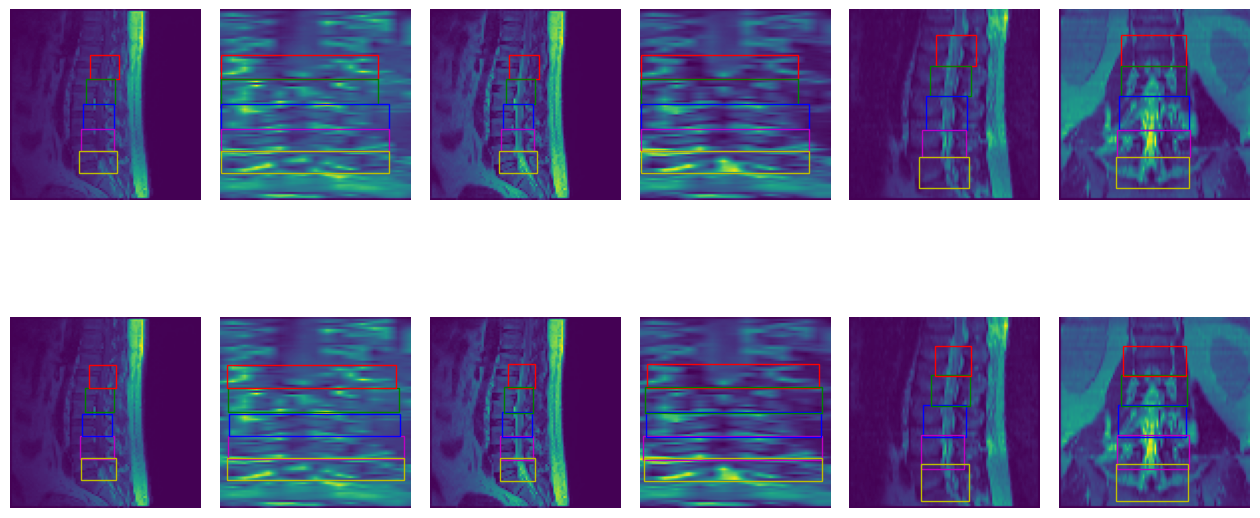

Fold: 1
Device set to cuda
Initializing feature extractor model:  resnet_18_23dataset
--------------------
Generating  resnet_18_23dataset  model...
Done
Loading pretrained weights...
loaded pretrained weights


Preparing data:   0%|          | 0/1579 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/395 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Epoch 2/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0008580858120694757 || map_50: 0.0019801980815827847 || map_75: 0.0 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0009900990407913923 || map_50: 0.0019801980815827847 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.0005940594128333032 || map_50: 0.0019801980815827847 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Epoch 3/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.06639210134744644 || map_50: 0.2015947848558426 || map_75: 0.018625890836119652 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.07508216053247452 || map_50: 0.22716408967971802 || map_75: 0.02390456385910511 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.06666220724582672 || map_50: 0.19304344058036804 || map_75: 0.023318002000451088 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0642610713839531 || map_50: 0.19395823776721954 || map_75: 0.017789166420698166 || map_per_class: -1.0 ||  

Epoch 4/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.12369771301746368 || map_50: 0.3796050250530243 || map_75: 0.029223991557955742 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.12302272766828537 || map_50: 0.3854868710041046 || map_75: 0.026178861036896706 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.13195833563804626 || map_50: 0.3883765935897827 || map_75: 0.034844525158405304 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.12220198661088943 || map_50: 0.37701812386512756 || map_75: 0.028999825939536095 || map_per_class: -1.0 ||  

Epoch 5/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.33232975006103516 || map_50: 0.7114464044570923 || map_75: 0.21650579571723938 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.32702478766441345 || map_50: 0.6903541088104248 || map_75: 0.21583789587020874 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.3392713963985443 || map_50: 0.7369594573974609 || map_75: 0.21457037329673767 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.33519506454467773 || map_50: 0.7135792374610901 || map_75: 0.22427716851234436 || map_per_class: -1.0 ||  

Epoch 6/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.38187044858932495 || map_50: 0.8241609334945679 || map_75: 0.24859312176704407 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.38007470965385437 || map_50: 0.8190286159515381 || map_75: 0.24611712992191315 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.38910889625549316 || map_50: 0.8295453786849976 || map_75: 0.25413432717323303 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.38031578063964844 || map_50: 0.8189656734466553 || map_75: 0.25424453616142273 || map_per_class: -1.0 ||  

Epoch 7/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.387263685464859 || map_50: 0.8873690962791443 || map_75: 0.19599579274654388 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.38205915689468384 || map_50: 0.8758853673934937 || map_75: 0.19161053001880646 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.396368145942688 || map_50: 0.8994897603988647 || map_75: 0.2033369392156601 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.3870159685611725 || map_50: 0.8915077447891235 || map_75: 0.20476937294006348 || map_per_class: -1.0 ||  

Epoch 8/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.4502841830253601 || map_50: 0.860894501209259 || map_75: 0.40943706035614014 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.45383158326148987 || map_50: 0.8615663051605225 || map_75: 0.4138386845588684 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.4550219476222992 || map_50: 0.8679692149162292 || map_75: 0.4094950556755066 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.4456290900707245 || map_50: 0.8484550714492798 || map_75: 0.41561728715896606 || map_per_class: -1.0 ||  

Epoch 9/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.37535783648490906 || map_50: 0.7756556272506714 || map_75: 0.2857363224029541 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.3791530132293701 || map_50: 0.7698552012443542 || map_75: 0.2877739667892456 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.3748669922351837 || map_50: 0.7763878703117371 || map_75: 0.28942158818244934 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.3780073821544647 || map_50: 0.7822226881980896 || map_75: 0.294515460729599 || map_per_class: -1.0 ||  

Epoch 10/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.5207483768463135 || map_50: 0.9176309704780579 || map_75: 0.5465331673622131 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.5224483609199524 || map_50: 0.9073905348777771 || map_75: 0.557890772819519 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.5173325538635254 || map_50: 0.9200960397720337 || map_75: 0.5284965634346008 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.5244083404541016 || map_50: 0.9182575345039368 || map_75: 0.5584980249404907 || map_per_class: -1.0 ||  



/tmp/ipykernel_35919/2416029966.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = color_dict[int(l)]


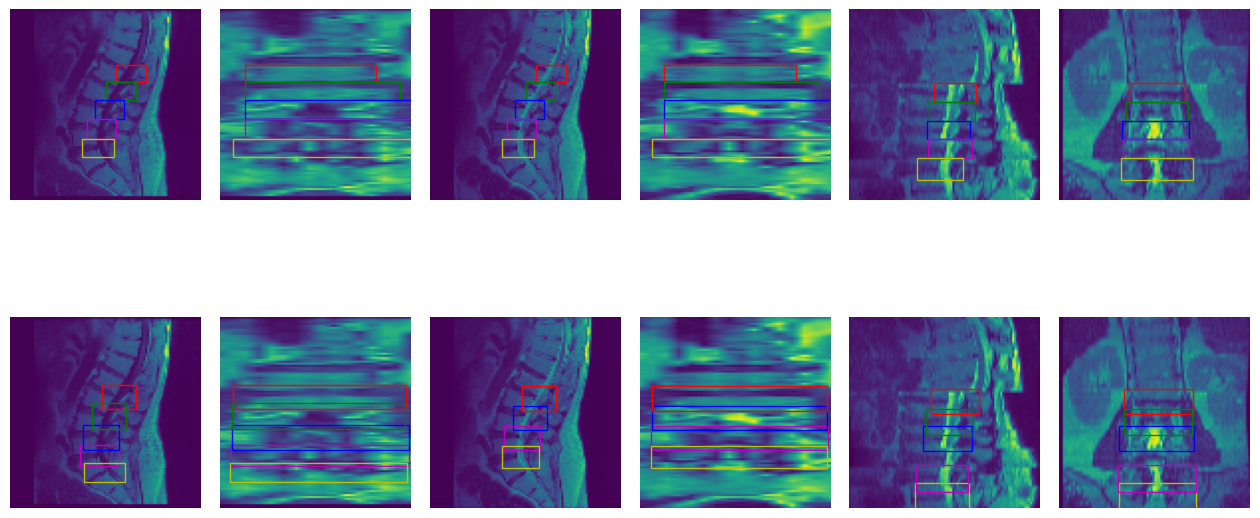

Fold: 2
Device set to cuda
Initializing feature extractor model:  resnet_18_23dataset
--------------------
Generating  resnet_18_23dataset  model...
Done
Loading pretrained weights...
loaded pretrained weights


Preparing data:   0%|          | 0/1579 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/395 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Epoch 2/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.009343552403151989 || map_50: 0.024839702993631363 || map_75: 0.0060698240995407104 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.008735960349440575 || map_50: 0.021757349371910095 || map_75: 0.007439886685460806 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.013957954943180084 || map_50: 0.03587310388684273 || map_75: 0.007029870990663767 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.005009968765079975 || map_50: 0.015828734263777733 || map_75: 0.002094091847538948 || map_per_class: -1.0 ||  

Epoch 3/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.058591801673173904 || map_50: 0.14228646457195282 || map_75: 0.030897796154022217 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.055115003138780594 || map_50: 0.12971317768096924 || map_75: 0.032617513090372086 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.05723467841744423 || map_50: 0.1424436867237091 || map_75: 0.025434207171201706 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.06614535301923752 || map_50: 0.15830713510513306 || map_75: 0.036176666617393494 || map_per_class: -1.0 ||  

Epoch 4/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.22490347921848297 || map_50: 0.627249538898468 || map_75: 0.05603662133216858 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.22962163388729095 || map_50: 0.6297821402549744 || map_75: 0.06337016075849533 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.23064571619033813 || map_50: 0.6514737606048584 || map_75: 0.05756933614611626 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.22710852324962616 || map_50: 0.6213483214378357 || map_75: 0.06053388863801956 || map_per_class: -1.0 ||  

Epoch 5/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.24099279940128326 || map_50: 0.641150951385498 || map_75: 0.07486546039581299 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.24589137732982635 || map_50: 0.6545261144638062 || map_75: 0.07767836004495621 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.250354140996933 || map_50: 0.6450462937355042 || map_75: 0.08694273978471756 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.24015198647975922 || map_50: 0.633264422416687 || map_75: 0.07598432153463364 || map_per_class: -1.0 ||  

Epoch 6/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.38752076029777527 || map_50: 0.8540924787521362 || map_75: 0.25977084040641785 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4127230942249298 || map_50: 0.8865675330162048 || map_75: 0.2833125591278076 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.38221481442451477 || map_50: 0.8575091361999512 || map_75: 0.24674998223781586 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.39026951789855957 || map_50: 0.8501095175743103 || map_75: 0.28297752141952515 || map_per_class: -1.0 ||  

Epoch 7/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.39277184009552 || map_50: 0.8822064995765686 || map_75: 0.22662237286567688 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4112614691257477 || map_50: 0.8986698389053345 || map_75: 0.2526412606239319 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.3833085000514984 || map_50: 0.8732379078865051 || map_75: 0.21344859898090363 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.4001535177230835 || map_50: 0.8855111002922058 || map_75: 0.24605341255664825 || map_per_class: -1.0 ||  

Epoch 8/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.4485500156879425 || map_50: 0.8914045691490173 || map_75: 0.3589092493057251 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.45300713181495667 || map_50: 0.8991990685462952 || map_75: 0.3633151054382324 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.45431047677993774 || map_50: 0.8960416913032532 || map_75: 0.3648519814014435 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.45677450299263 || map_50: 0.8966839909553528 || map_75: 0.3818800151348114 || map_per_class: -1.0 ||  

Epoch 9/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.43367472290992737 || map_50: 0.8934687376022339 || map_75: 0.3390747308731079 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.45147258043289185 || map_50: 0.9100225567817688 || map_75: 0.366657555103302 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.4269638657569885 || map_50: 0.8885648250579834 || map_75: 0.3313318192958832 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.44074538350105286 || map_50: 0.8948962092399597 || map_75: 0.3529427647590637 || map_per_class: -1.0 ||  

Epoch 10/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.46215152740478516 || map_50: 0.9156283140182495 || map_75: 0.37889745831489563 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4755691587924957 || map_50: 0.9268299341201782 || map_75: 0.40408143401145935 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.4606172740459442 || map_50: 0.916973352432251 || map_75: 0.3735602796077728 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.4674244821071625 || map_50: 0.9182910919189453 || map_75: 0.3919963538646698 || map_per_class: -1.0 ||  



/tmp/ipykernel_35919/2416029966.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = color_dict[int(l)]


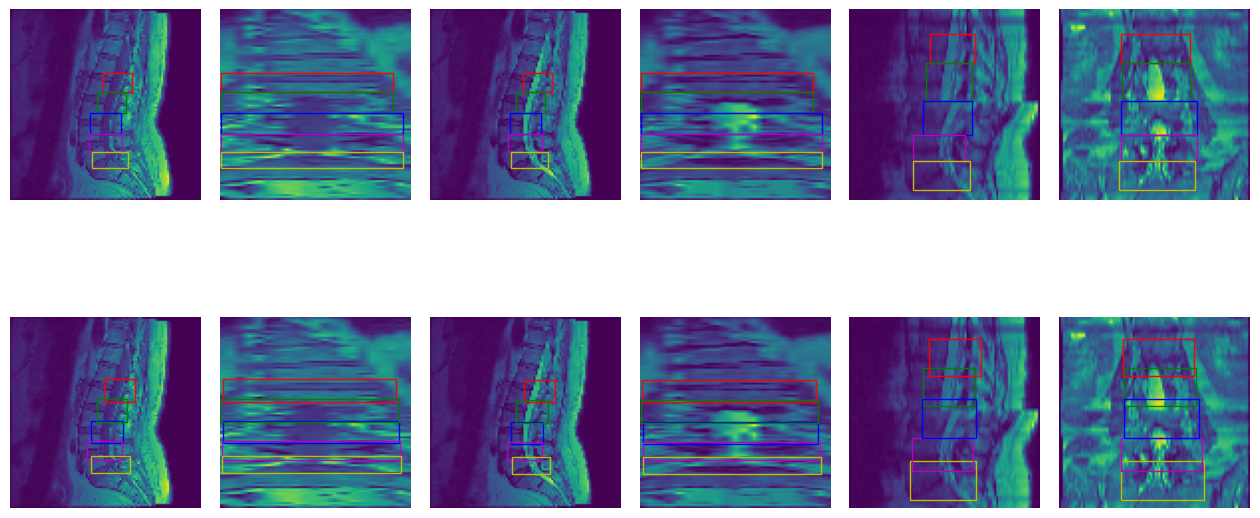

Fold: 3
Device set to cuda
Initializing feature extractor model:  resnet_18_23dataset
--------------------
Generating  resnet_18_23dataset  model...
Done
Loading pretrained weights...
loaded pretrained weights


Preparing data:   0%|          | 0/1579 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/395 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Epoch 2/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0007920791977085173 || map_50: 0.0019801980815827847 || map_75: 0.0 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.00039603959885425866 || map_50: 0.0019801980815827847 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0007920791977085173 || map_50: 0.0019801980815827847 || map_75: 0.0 || map_per_class: -1.0 ||  

Epoch 3/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.12065518647432327 || map_50: 0.3685045838356018 || map_75: 0.02822662889957428 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.11475180089473724 || map_50: 0.3476354777812958 || map_75: 0.02828075736761093 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.1254831850528717 || map_50: 0.3722664713859558 || map_75: 0.02732229232788086 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.12362513691186905 || map_50: 0.3854694366455078 || map_75: 0.03132402151823044 || map_per_class: -1.0 ||  

Epoch 4/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.22776192426681519 || map_50: 0.5145163536071777 || map_75: 0.12465797364711761 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.21587151288986206 || map_50: 0.4870319962501526 || map_75: 0.12372929602861404 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.24302606284618378 || map_50: 0.5355124473571777 || map_75: 0.14411619305610657 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.23452964425086975 || map_50: 0.5368892550468445 || map_75: 0.12629707157611847 || map_per_class: -1.0 ||  

Epoch 5/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.3331930935382843 || map_50: 0.8254603147506714 || map_75: 0.1315472573041916 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.3476656675338745 || map_50: 0.8341718912124634 || map_75: 0.1430804282426834 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.3291032016277313 || map_50: 0.80929034948349 || map_75: 0.1357986330986023 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.33129310607910156 || map_50: 0.8334394097328186 || map_75: 0.13382971286773682 || map_per_class: -1.0 ||  

Epoch 6/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.3309715688228607 || map_50: 0.6947553753852844 || map_75: 0.2471916675567627 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.3398880660533905 || map_50: 0.7001726031303406 || map_75: 0.2665499746799469 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.336906760931015 || map_50: 0.7066179513931274 || map_75: 0.2578025758266449 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.3263455927371979 || map_50: 0.6939039826393127 || map_75: 0.237033873796463 || map_per_class: -1.0 ||  

Epoch 7/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.4386531114578247 || map_50: 0.8862226605415344 || map_75: 0.32575729489326477 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4394150674343109 || map_50: 0.8916414380073547 || map_75: 0.33630606532096863 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.44077056646347046 || map_50: 0.885679304599762 || map_75: 0.33733686804771423 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.44333863258361816 || map_50: 0.89024418592453 || map_75: 0.31918010115623474 || map_per_class: -1.0 ||  

Epoch 8/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.4813474118709564 || map_50: 0.8784072399139404 || map_75: 0.47712162137031555 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4965902864933014 || map_50: 0.8887141942977905 || map_75: 0.492217481136322 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.4761144518852234 || map_50: 0.8760403990745544 || map_75: 0.4794909954071045 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.4773414134979248 || map_50: 0.8745514154434204 || map_75: 0.4706125855445862 || map_per_class: -1.0 ||  

Epoch 9/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.4798976182937622 || map_50: 0.9095132946968079 || map_75: 0.4345438778400421 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.490719735622406 || map_50: 0.9128016233444214 || map_75: 0.4718894064426422 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.47141212224960327 || map_50: 0.9044537544250488 || map_75: 0.405822217464447 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.485276460647583 || map_50: 0.9172320365905762 || map_75: 0.4447857737541199 || map_per_class: -1.0 ||  

Epoch 10/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.4401654303073883 || map_50: 0.9051048755645752 || map_75: 0.31479305028915405 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4545426666736603 || map_50: 0.9100860357284546 || map_75: 0.3474833369255066 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.4377876818180084 || map_50: 0.9059218764305115 || map_75: 0.2989320158958435 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.43810299038887024 || map_50: 0.9036584496498108 || map_75: 0.3153496980667114 || map_per_class: -1.0 ||  



/tmp/ipykernel_35919/2416029966.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = color_dict[int(l)]


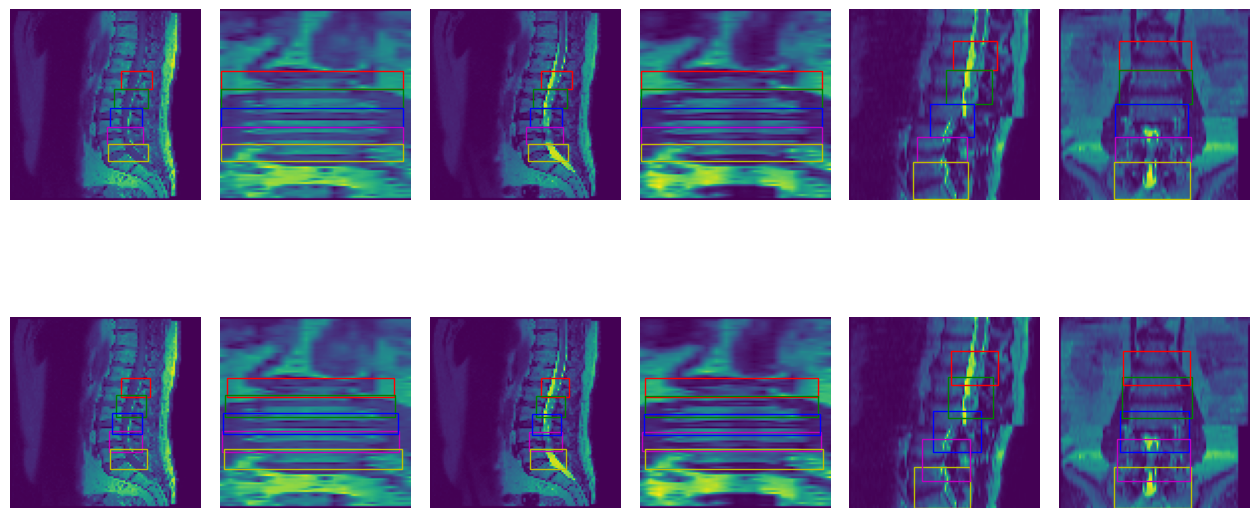

Fold: 4
Device set to cuda
Initializing feature extractor model:  resnet_18_23dataset
--------------------
Generating  resnet_18_23dataset  model...
Done
Loading pretrained weights...
loaded pretrained weights


Preparing data:   0%|          | 0/1579 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/395 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0 || map_50: 0.0 || map_75: 0.0 || map_per_class: -1.0 ||  

Epoch 2/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.00924075860530138 || map_50: 0.019471125677227974 || map_75: 0.005904721096158028 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.008406229317188263 || map_50: 0.015165651217103004 || map_75: 0.009007362648844719 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.01022582408040762 || map_50: 0.01989092491567135 || map_75: 0.007380166556686163 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.008177903480827808 || map_50: 0.015709571540355682 || map_75: 0.005192519165575504 || map_per_class: -1.0 ||  

Epoch 3/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.03991254046559334 || map_50: 0.14578838646411896 || map_75: 0.011730605736374855 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.03654130920767784 || map_50: 0.13532570004463196 || map_75: 0.00603604968637228 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.04188418760895729 || map_50: 0.147396057844162 || map_75: 0.013460393063724041 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.04151327908039093 || map_50: 0.15271279215812683 || map_75: 0.014144649729132652 || map_per_class: -1.0 ||  

Epoch 4/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.31907904148101807 || map_50: 0.743015468120575 || map_75: 0.1642650067806244 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.322480708360672 || map_50: 0.7479848861694336 || map_75: 0.1726844608783722 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.30959099531173706 || map_50: 0.7251644730567932 || map_75: 0.16342097520828247 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.3261485695838928 || map_50: 0.7535325288772583 || map_75: 0.15917512774467468 || map_per_class: -1.0 ||  

Epoch 5/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.31648898124694824 || map_50: 0.753764808177948 || map_75: 0.15201254189014435 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.30861952900886536 || map_50: 0.7450994253158569 || map_75: 0.13942186534404755 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.32078972458839417 || map_50: 0.7533040642738342 || map_75: 0.17056827247142792 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.32739078998565674 || map_50: 0.7588213086128235 || map_75: 0.1617186963558197 || map_per_class: -1.0 ||  

Epoch 6/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.4275268614292145 || map_50: 0.864599347114563 || map_75: 0.3412795662879944 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.4238101840019226 || map_50: 0.8705500364303589 || map_75: 0.32354289293289185 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.43112829327583313 || map_50: 0.8577681183815002 || map_75: 0.35869860649108887 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.4336355924606323 || map_50: 0.8613870143890381 || map_75: 0.3650459945201874 || map_per_class: -1.0 ||  

Epoch 7/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.42241933941841125 || map_50: 0.8813629150390625 || map_75: 0.3012087941169739 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.42234084010124207 || map_50: 0.890228807926178 || map_75: 0.2916646897792816 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.42250117659568787 || map_50: 0.8843065500259399 || map_75: 0.3093550205230713 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.43046000599861145 || map_50: 0.8756380677223206 || map_75: 0.3244710862636566 || map_per_class: -1.0 ||  

Epoch 8/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.376154363155365 || map_50: 0.8509225249290466 || map_75: 0.18325182795524597 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.37298113107681274 || map_50: 0.8458778262138367 || map_75: 0.1846964806318283 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.3727268576622009 || map_50: 0.8431462049484253 || map_75: 0.18780536949634552 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.38587483763694763 || map_50: 0.8603541851043701 || map_75: 0.19372473657131195 || map_per_class: -1.0 ||  

Epoch 9/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.47395801544189453 || map_50: 0.8959299921989441 || map_75: 0.4327080547809601 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.47754859924316406 || map_50: 0.893273651599884 || map_75: 0.4517032504081726 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.47035446763038635 || map_50: 0.8989360332489014 || map_75: 0.4214816391468048 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.4764353930950165 || map_50: 0.8889865875244141 || map_75: 0.43846139311790466 || map_per_class: -1.0 ||  

Epoch 10/10


  0%|          | 0/1579 [00:00<?, ?batch/s]

  0%|          | 0/395 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.5094727277755737 || map_50: 0.9220142364501953 || map_75: 0.5233083367347717 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.5125625729560852 || map_50: 0.9256489276885986 || map_75: 0.5350459218025208 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.5143818855285645 || map_50: 0.9250365495681763 || map_75: 0.5256224870681763 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.5066715478897095 || map_50: 0.9116637110710144 || map_75: 0.524662971496582 || map_per_class: -1.0 ||  



/tmp/ipykernel_35919/2416029966.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = color_dict[int(l)]


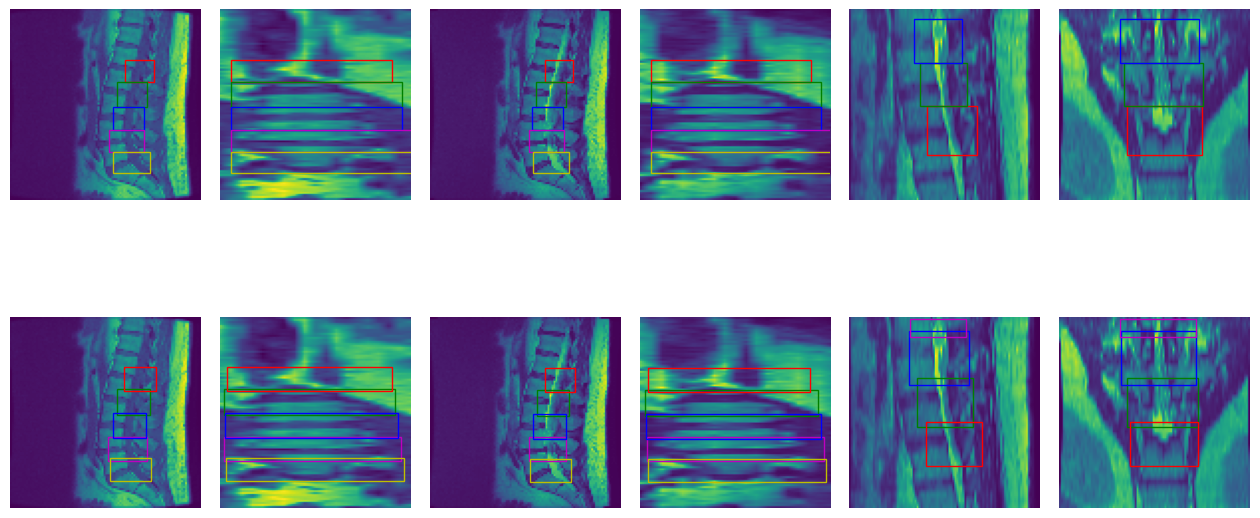

[{'model_name': 'level_detector_mednet18_96x3',
  'backbone': 'resnet_18',
  'conv_type': '3d',
  'use_reg_for_cls': False,
  'mix_strategy': 'combined',
  'best_epoch': 9,
  'general_map': tensor(0.4770),
  'general_map_50': tensor(0.9135),
  'general_map_75': tensor(0.4261),
  'general_map_per_class': tensor(-1.),
  'sagittal_sagittal_map': tensor(0.4880),
  'sagittal_sagittal_map_50': tensor(0.9220),
  'sagittal_sagittal_map_75': tensor(0.4442),
  'sagittal_sagittal_map_per_class': tensor(-1.),
  'axial_sagittal_map': tensor(0.4816),
  'axial_sagittal_map_50': tensor(0.9118),
  'axial_sagittal_map_75': tensor(0.4370),
  'axial_sagittal_map_per_class': tensor(-1.),
  'sagittal_t2_sagittal_map': tensor(0.4707),
  'sagittal_t2_sagittal_map_50': tensor(0.9101),
  'sagittal_t2_sagittal_map_75': tensor(0.4159),
  'sagittal_t2_sagittal_map_per_class': tensor(-1.)},
 {'model_name': 'level_detector_mednet18_96x3',
  'backbone': 'resnet_18',
  'conv_type': '3d',
  'use_reg_for_cls': False,
  

In [38]:
torch.set_printoptions(profile="full")
kfoldCV(5, trainer_config, model_config)

In [39]:
trainer_config = {
    "print_evaluation": True,
    "steps_per_plot": 10,

    "checkpoints": False,
    "save_path": "/workspaces/RSNA_LSDC/model_weight",
    "step_per_save":100,

    "model_name": "level_detector_mednet18_96x3",
    "train_dataset_config": train_dataset_config,
    "val_dataset_config": val_dataset_config,

    "optimizer": torch.optim.AdamW, #torch.optim.AdamW,#torch.optim.Adam,
    "optimizer_params": {'lr': 2e-4, 'weight_decay': 1e-3},#, 'momentum': 0.98, 'weight_decay': 1e-3},#, 'momentum':0.98, 'weight_decay':1e-5},#, 'momentum':0.9},
    "scheduler": torch.optim.lr_scheduler.ExponentialLR, #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, #torch.optim.lr_scheduler.ExponentialLR, #torch.optim.lr_scheduler.OneCycleLR
    "scheduler_params": {'gamma':0.99}, #{'T_0': 10, 'T_mult': 2, 'eta_min':1e-6}, #{'T_0': 2, 'T_mult': 2, 'eta_min':3e-5}, #{'max_lr': 0.001, 'epochs': None, 'steps_per_epoch':None}, {'gamma':0.9}

    "epochs": 10, 
    "batch_size": 1,
    "early_stopping": False,
    "save_model": False,
    "early_stopping_treshold": 0.1
}

model_config = {
    'backbone_name': 'efficientnet_b0', 
    'series_dim': [train_dataset_config['series_len']]+train_dataset_config['im_size'],
    'use_features': [0,1],

    'reg_max': 12, 
    'pretrained': True, 
    'num_classes':1 if train_dataset_config['one_label'] else 5,
    'head_conv_mode': '3d',
    'use_reg_for_cls': False
    }

Fold: 0
Device set to cuda


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Convert layer weights: blocks.0.0.conv_dw.weight. Shape: torch.Size([32, 1, 3, 3]) -> torch.Size([32, 1, 3, 3, 3])
Convert layer weights: blocks.0.0.conv_pw.weight. Shape: torch.Size([16, 32, 1, 1]) -> torch.Size([16, 32, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_expand.weight. Shape: torch.Size([32, 8, 1, 1]) -> torch.Size([32, 8, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_reduce.weight. Shape: torch.Size([8, 32, 1, 1]) -> torch.Size([8, 32, 1, 1, 1])
Convert layer weights: blocks.1.0.conv_dw.weight. Shape: torch.Size([96, 1, 3, 3]) -> torch.Size([96, 1, 3, 3, 3])
Convert layer weights: blocks.1.0.conv_pw.weight. Shape: torch.Size([96, 16, 1, 1]) -> torch.Size([96, 16, 1, 1, 1])
Convert layer weights: blocks.1.0.conv_pwl.weight. Shape: torch.Size([24, 96, 1, 1]) -> torch.Size([24, 96, 1, 1, 1])
Convert layer weights: blocks.1.0.se.conv_expand.weight. Shape: torch.Size([96, 4, 1, 1]) -> torch.Size([96, 4, 1, 1, 1])
Convert layer weights: blocks.1.0.se.conv_reduce.wei

Preparing data:   0%|          | 0/1315 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/659 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0015909801004454494 || map_50: 0.003497400088235736 || map_75: 0.0021325210109353065 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0015781577676534653 || map_50: 0.004500450100749731 || map_75: 0.0020402041263878345 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.00047272886149585247 || map_50: 0.0019471946870908141 || map_75: 9.900989971356466e-05 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0004963655374012887 || map_50: 0.0014851485611870885 || map_75: 0.00039603959885425866 || map_per_class: -1.0 ||  

Epoch 2/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.014072003774344921 || map_50: 0.06522864103317261 || map_75: 0.002774802502244711 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.012537459842860699 || map_50: 0.05627349391579628 || map_75: 0.002149929292500019 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.012630338780581951 || map_50: 0.06070579215884209 || map_75: 0.0026784250512719154 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.016346300020813942 || map_50: 0.0779983401298523 || map_75: 0.0015142931370064616 || map_per_class: -1.0 ||  

Epoch 3/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0675256997346878 || map_50: 0.22585150599479675 || map_75: 0.017704036086797714 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.06395337730646133 || map_50: 0.21395239233970642 || map_75: 0.018794136121869087 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.06953959912061691 || map_50: 0.22991925477981567 || map_75: 0.01985001750290394 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.07549859583377838 || map_50: 0.24657325446605682 || map_75: 0.017771519720554352 || map_per_class: -1.0 ||  

Epoch 4/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.08924680203199387 || map_50: 0.30770978331565857 || map_75: 0.016866903752088547 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.08409415930509567 || map_50: 0.28905194997787476 || map_75: 0.017169002443552017 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.09086395800113678 || map_50: 0.3087337911128998 || map_75: 0.018783628940582275 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.09753604978322983 || map_50: 0.3320005238056183 || map_75: 0.01852058432996273 || map_per_class: -1.0 ||  

Epoch 5/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.1667402982711792 || map_50: 0.4692426919937134 || map_75: 0.055876970291137695 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.15789006650447845 || map_50: 0.4417598843574524 || map_75: 0.05566557124257088 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.17124809324741364 || map_50: 0.4814395606517792 || map_75: 0.05886639282107353 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.17705735564231873 || map_50: 0.49145108461380005 || map_75: 0.06203805282711983 || map_per_class: -1.0 ||  

Epoch 6/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.20208534598350525 || map_50: 0.5032124519348145 || map_75: 0.09961282461881638 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.1989772766828537 || map_50: 0.4912903606891632 || map_75: 0.10106123238801956 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.21168400347232819 || map_50: 0.5171635746955872 || map_75: 0.10902213305234909 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.20382645726203918 || map_50: 0.5116382241249084 || map_75: 0.09493214637041092 || map_per_class: -1.0 ||  

Epoch 7/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.1790914535522461 || map_50: 0.5623399019241333 || map_75: 0.03660064935684204 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.17165763676166534 || map_50: 0.5417459607124329 || map_75: 0.03788842260837555 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.184427410364151 || map_50: 0.5816158652305603 || map_75: 0.03636720031499863 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.18690437078475952 || map_50: 0.5750139951705933 || map_75: 0.04058052971959114 || map_per_class: -1.0 ||  

Epoch 8/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.23531657457351685 || map_50: 0.5411763787269592 || map_75: 0.14274214208126068 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.23486606776714325 || map_50: 0.5252230763435364 || map_75: 0.15669022500514984 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.2388046532869339 || map_50: 0.5559037327766418 || map_75: 0.1374719738960266 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.23908492922782898 || map_50: 0.5528746843338013 || map_75: 0.1464117020368576 || map_per_class: -1.0 ||  

Epoch 9/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.27163341641426086 || map_50: 0.6113060712814331 || map_75: 0.16547797620296478 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.26564568281173706 || map_50: 0.5845016241073608 || map_75: 0.17070281505584717 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.2761058211326599 || map_50: 0.6227253079414368 || map_75: 0.17102667689323425 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.2779894471168518 || map_50: 0.6284714937210083 || map_75: 0.1619666963815689 || map_per_class: -1.0 ||  

Epoch 10/10


  0%|          | 0/1315 [00:00<?, ?batch/s]

  0%|          | 0/659 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.28903326392173767 || map_50: 0.614130973815918 || map_75: 0.20835615694522858 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.2878391146659851 || map_50: 0.5927544236183167 || map_75: 0.23030592501163483 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.2950518727302551 || map_50: 0.6220157146453857 || map_75: 0.21722759306430817 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.2940378785133362 || map_50: 0.6400853991508484 || map_75: 0.19767428934574127 || map_per_class: -1.0 ||  



/tmp/ipykernel_35919/2416029966.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = color_dict[int(l)]


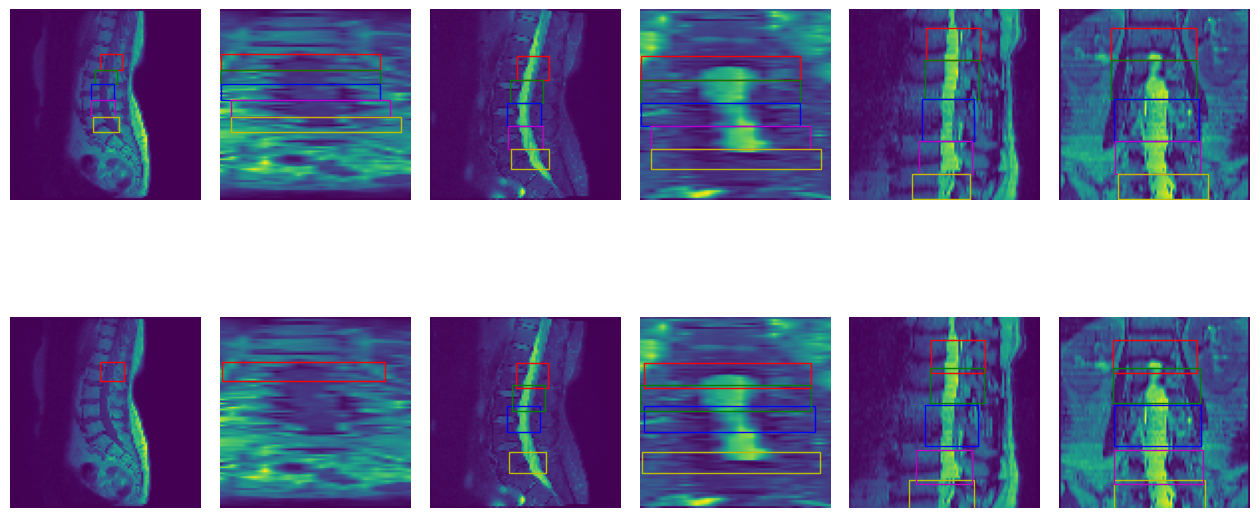

Fold: 1
Device set to cuda


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Convert layer weights: blocks.0.0.conv_dw.weight. Shape: torch.Size([32, 1, 3, 3]) -> torch.Size([32, 1, 3, 3, 3])
Convert layer weights: blocks.0.0.conv_pw.weight. Shape: torch.Size([16, 32, 1, 1]) -> torch.Size([16, 32, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_expand.weight. Shape: torch.Size([32, 8, 1, 1]) -> torch.Size([32, 8, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_reduce.weight. Shape: torch.Size([8, 32, 1, 1]) -> torch.Size([8, 32, 1, 1, 1])
Convert layer weights: blocks.1.0.conv_dw.weight. Shape: torch.Size([96, 1, 3, 3]) -> torch.Size([96, 1, 3, 3, 3])
Convert layer weights: blocks.1.0.conv_pw.weight. Shape: torch.Size([96, 16, 1, 1]) -> torch.Size([96, 16, 1, 1, 1])
Convert layer weights: blocks.1.0.conv_pwl.weight. Shape: torch.Size([24, 96, 1, 1]) -> torch.Size([24, 96, 1, 1, 1])
Convert layer weights: blocks.1.0.se.conv_expand.weight. Shape: torch.Size([96, 4, 1, 1]) -> torch.Size([96, 4, 1, 1, 1])
Convert layer weights: blocks.1.0.se.conv_reduce.wei

Preparing data:   0%|          | 0/1317 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/657 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.0019054972799494863 || map_50: 0.007037008181214333 || map_75: 8.899766544345766e-05 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0024942923337221146 || map_50: 0.007653265260159969 || map_75: 7.072135485941544e-05 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.001996102510020137 || map_50: 0.006810109131038189 || map_75: 0.00018859028932638466 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0018852733774110675 || map_50: 0.008613737300038338 || map_75: 5.824111940455623e-05 || map_per_class: -1.0 ||  

Epoch 2/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.035843294113874435 || map_50: 0.1449337601661682 || map_75: 0.004999575670808554 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0322214812040329 || map_50: 0.13290487229824066 || map_75: 0.003983295056968927 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.034416310489177704 || map_50: 0.14228807389736176 || map_75: 0.005312029737979174 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.04303768649697304 || map_50: 0.16631346940994263 || map_75: 0.006992108188569546 || map_per_class: -1.0 ||  

Epoch 3/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.07334382086992264 || map_50: 0.2928996980190277 || map_75: 0.006264257710427046 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.07058361917734146 || map_50: 0.28412938117980957 || map_75: 0.005374234169721603 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.07269424200057983 || map_50: 0.2920522093772888 || map_75: 0.005665959324687719 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.08177664875984192 || map_50: 0.3127473294734955 || map_75: 0.011306079104542732 || map_per_class: -1.0 ||  

Epoch 4/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.1327933669090271 || map_50: 0.3700861632823944 || map_75: 0.049938686192035675 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.13328738510608673 || map_50: 0.3765689730644226 || map_75: 0.05038502812385559 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.12626266479492188 || map_50: 0.3555215895175934 || map_75: 0.046134453266859055 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.1437872350215912 || map_50: 0.3906741142272949 || map_75: 0.055108692497015 || map_per_class: -1.0 ||  

Epoch 5/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.17946983873844147 || map_50: 0.4909543991088867 || map_75: 0.0699855387210846 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.1809803694486618 || map_50: 0.4969891309738159 || map_75: 0.07111922651529312 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.1735266149044037 || map_50: 0.4805973172187805 || map_75: 0.06783223152160645 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.1879694014787674 || map_50: 0.5083184838294983 || map_75: 0.0743943452835083 || map_per_class: -1.0 ||  

Epoch 6/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.18242786824703217 || map_50: 0.48893317580223083 || map_75: 0.07913899421691895 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.18170812726020813 || map_50: 0.4873664975166321 || map_75: 0.07537712901830673 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.17224176228046417 || map_50: 0.4661417305469513 || map_75: 0.0687328353524208 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.19399769604206085 || map_50: 0.5086880326271057 || map_75: 0.09241580963134766 || map_per_class: -1.0 ||  

Epoch 7/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.226359561085701 || map_50: 0.54852694272995 || map_75: 0.11286163330078125 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.22251246869564056 || map_50: 0.5478178858757019 || map_75: 0.11099433153867722 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.22172176837921143 || map_50: 0.5388525724411011 || map_75: 0.10557223856449127 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.2384858876466751 || map_50: 0.5620303153991699 || map_75: 0.13089022040367126 || map_per_class: -1.0 ||  

Epoch 8/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.26522010564804077 || map_50: 0.6030442714691162 || map_75: 0.1647360920906067 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.2597043216228485 || map_50: 0.597307026386261 || map_75: 0.150961771607399 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.2630242705345154 || map_50: 0.6010811924934387 || map_75: 0.16579170525074005 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.27584517002105713 || map_50: 0.6099566221237183 || map_75: 0.1849723905324936 || map_per_class: -1.0 ||  

Epoch 9/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.2756264805793762 || map_50: 0.6074207425117493 || map_75: 0.1785885989665985 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.2738978862762451 || map_50: 0.606384813785553 || map_75: 0.17824877798557281 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.2700134515762329 || map_50: 0.5969309210777283 || map_75: 0.170442134141922 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.288450688123703 || map_50: 0.6203795075416565 || map_75: 0.20323781669139862 || map_per_class: -1.0 ||  

Epoch 10/10


  0%|          | 0/1317 [00:00<?, ?batch/s]

  0%|          | 0/657 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.2665117383003235 || map_50: 0.6060306429862976 || map_75: 0.15366661548614502 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.2620910704135895 || map_50: 0.6062917709350586 || map_75: 0.1480429321527481 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.2590511441230774 || map_50: 0.5919263958930969 || map_75: 0.14515851438045502 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.28196245431900024 || map_50: 0.6274691224098206 || map_75: 0.17674395442008972 || map_per_class: -1.0 ||  



/tmp/ipykernel_35919/2416029966.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = color_dict[int(l)]


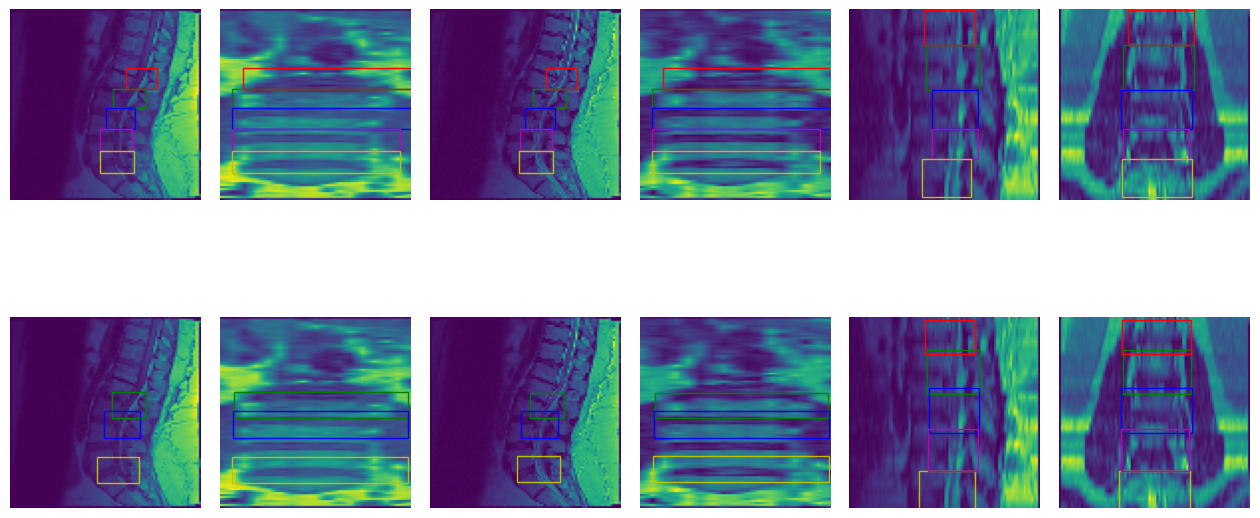

Fold: 2
Device set to cuda


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Convert layer weights: blocks.0.0.conv_dw.weight. Shape: torch.Size([32, 1, 3, 3]) -> torch.Size([32, 1, 3, 3, 3])
Convert layer weights: blocks.0.0.conv_pw.weight. Shape: torch.Size([16, 32, 1, 1]) -> torch.Size([16, 32, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_expand.weight. Shape: torch.Size([32, 8, 1, 1]) -> torch.Size([32, 8, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_reduce.weight. Shape: torch.Size([8, 32, 1, 1]) -> torch.Size([8, 32, 1, 1, 1])
Convert layer weights: blocks.1.0.conv_dw.weight. Shape: torch.Size([96, 1, 3, 3]) -> torch.Size([96, 1, 3, 3, 3])
Convert layer weights: blocks.1.0.conv_pw.weight. Shape: torch.Size([96, 16, 1, 1]) -> torch.Size([96, 16, 1, 1, 1])
Convert layer weights: blocks.1.0.conv_pwl.weight. Shape: torch.Size([24, 96, 1, 1]) -> torch.Size([24, 96, 1, 1, 1])
Convert layer weights: blocks.1.0.se.conv_expand.weight. Shape: torch.Size([96, 4, 1, 1]) -> torch.Size([96, 4, 1, 1, 1])
Convert layer weights: blocks.1.0.se.conv_reduce.wei

Preparing data:   0%|          | 0/1316 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/658 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.001818717224523425 || map_50: 0.006890573538839817 || map_75: 7.072135485941544e-05 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.0021592872217297554 || map_50: 0.007260726299136877 || map_75: 0.00012775471259374171 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.0018820890691131353 || map_50: 0.007766710594296455 || map_75: 9.900989971356466e-05 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.0023436276242136955 || map_50: 0.009095542132854462 || map_75: 6.000600114930421e-05 || map_per_class: -1.0 ||  

Epoch 2/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.022259388118982315 || map_50: 0.07728780061006546 || map_75: 0.005698844790458679 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.02524009719491005 || map_50: 0.087407186627388 || map_75: 0.005784068256616592 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.014753509312868118 || map_50: 0.0531596839427948 || map_75: 0.0037895306013524532 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.027450451627373695 || map_50: 0.09670954197645187 || map_75: 0.008218774572014809 || map_per_class: -1.0 ||  

Epoch 3/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.05544749274849892 || map_50: 0.2147304266691208 || map_75: 0.009551716968417168 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.056091245263814926 || map_50: 0.21800555288791656 || map_75: 0.009207803755998611 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.04901544377207756 || map_50: 0.18646802008152008 || map_75: 0.009070105850696564 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.06392277032136917 || map_50: 0.24633440375328064 || map_75: 0.009456727653741837 || map_per_class: -1.0 ||  

Epoch 4/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.11441338807344437 || map_50: 0.3720937967300415 || map_75: 0.026042811572551727 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.11129771918058395 || map_50: 0.3687603175640106 || map_75: 0.02227579988539219 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.10260433703660965 || map_50: 0.33348384499549866 || map_75: 0.028485247865319252 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.1350322961807251 || map_50: 0.42046821117401123 || map_75: 0.032579947263002396 || map_per_class: -1.0 ||  

Epoch 5/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.16966567933559418 || map_50: 0.4773050844669342 || map_75: 0.06424834579229355 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.17123715579509735 || map_50: 0.482044517993927 || map_75: 0.06480168551206589 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.15265657007694244 || map_50: 0.43524613976478577 || map_75: 0.05864517763257027 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.19236208498477936 || map_50: 0.5231577754020691 || map_75: 0.08185800164937973 || map_per_class: -1.0 ||  

Epoch 6/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.20101502537727356 || map_50: 0.5163384675979614 || map_75: 0.09371837973594666 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.19995474815368652 || map_50: 0.517966091632843 || map_75: 0.08569090813398361 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.18531692028045654 || map_50: 0.4776771366596222 || map_75: 0.08601024001836777 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.22349606454372406 || map_50: 0.5573551058769226 || map_75: 0.11401338875293732 || map_per_class: -1.0 ||  

Epoch 7/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.210621178150177 || map_50: 0.5556856393814087 || map_75: 0.08742053061723709 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.2124650925397873 || map_50: 0.5549659132957458 || map_75: 0.09325219690799713 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.1918267458677292 || map_50: 0.5166566371917725 || map_75: 0.07738251984119415 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.229295015335083 || map_50: 0.5892748832702637 || map_75: 0.09442965686321259 || map_per_class: -1.0 ||  

Epoch 8/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.2656121253967285 || map_50: 0.5827620625495911 || map_75: 0.17162145674228668 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.2632540166378021 || map_50: 0.5760971307754517 || map_75: 0.17651861906051636 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.2500179409980774 || map_50: 0.5551361441612244 || map_75: 0.16039425134658813 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.28515759110450745 || map_50: 0.618553638458252 || map_75: 0.18509306013584137 || map_per_class: -1.0 ||  

Epoch 9/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.2567846179008484 || map_50: 0.5896186828613281 || map_75: 0.14409466087818146 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.2625933289527893 || map_50: 0.6005118489265442 || map_75: 0.1422790288925171 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.23777808248996735 || map_50: 0.557765543460846 || map_75: 0.12844647467136383 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.27688518166542053 || map_50: 0.6238628625869751 || map_75: 0.16537216305732727 || map_per_class: -1.0 ||  

Epoch 10/10


  0%|          | 0/1316 [00:00<?, ?batch/s]

  0%|          | 0/658 [00:00<?, ?batch/s]

All mAP validation metrics: map: 0.2917144298553467 || map_50: 0.6349391341209412 || map_75: 0.19313588738441467 || map_per_class: -1.0 || 
Validation mAP for input series with type sagittal: 
    For output series with type sagittal: map: 0.2930420935153961 || map_50: 0.6443631052970886 || map_75: 0.1792331039905548 || map_per_class: -1.0 ||  

Validation mAP for input series with type axial: 
    For output series with type sagittal: map: 0.2768300175666809 || map_50: 0.599607527256012 || map_75: 0.18679432570934296 || map_per_class: -1.0 ||  

Validation mAP for input series with type sagittal_t2: 
    For output series with type sagittal: map: 0.3071620464324951 || map_50: 0.6615096926689148 || map_75: 0.21647128462791443 || map_per_class: -1.0 ||  



/tmp/ipykernel_35919/2416029966.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = color_dict[int(l)]


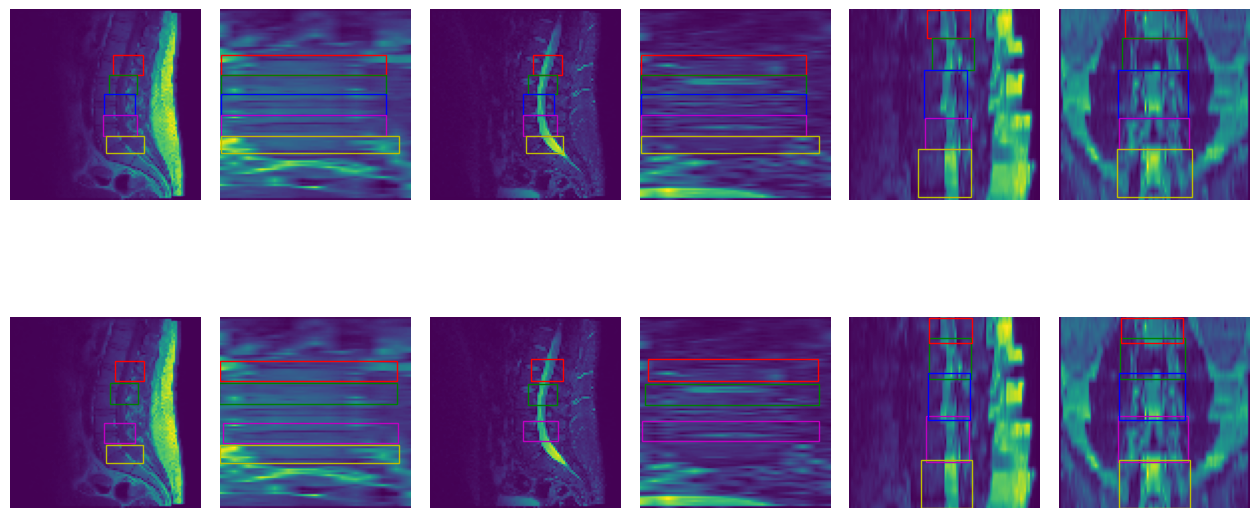

[{'model_name': 'level_detector_mednet18_96x3',
  'backbone': 'efficientnet_b0',
  'conv_type': '3d',
  'use_reg_for_cls': False,
  'mix_strategy': 'combined',
  'best_epoch': 9,
  'general_map': tensor(0.2890),
  'general_map_50': tensor(0.6141),
  'general_map_75': tensor(0.2084),
  'general_map_per_class': tensor(-1.),
  'sagittal_sagittal_map': tensor(0.2878),
  'sagittal_sagittal_map_50': tensor(0.5928),
  'sagittal_sagittal_map_75': tensor(0.2303),
  'sagittal_sagittal_map_per_class': tensor(-1.),
  'axial_sagittal_map': tensor(0.2951),
  'axial_sagittal_map_50': tensor(0.6220),
  'axial_sagittal_map_75': tensor(0.2172),
  'axial_sagittal_map_per_class': tensor(-1.),
  'sagittal_t2_sagittal_map': tensor(0.2940),
  'sagittal_t2_sagittal_map_50': tensor(0.6401),
  'sagittal_t2_sagittal_map_75': tensor(0.1977),
  'sagittal_t2_sagittal_map_per_class': tensor(-1.)},
 {'model_name': 'level_detector_mednet18_96x3',
  'backbone': 'efficientnet_b0',
  'conv_type': '3d',
  'use_reg_for_cls

In [40]:
kfoldCV(3, trainer_config, model_config)